## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import psutil
from multiprocessing import Process, Queue
from scipy.stats import pearsonr
from goatools import go_search
from dynamicTreeCut import cutreeHybrid
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram
from biokit.viz import corrplot
from biokit import corrplot as cp
import scipy.cluster.hierarchy as spc
import matplotlib
import matplotlib.pyplot as plt
from dynamicTreeCut import cutreeHybrid
from dynamicTreeCut import *
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram
from biokit.viz import corrplot
from biokit import corrplot as cp
import scipy.cluster.hierarchy as spc
from matplotlib.colors import to_hex
from matplotlib import gridspec
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy.stats import norm
import statsmodels as st
from matplotlib.patches import Rectangle
# import statsmodels.api as sm

## Setting base directory

In [2]:
Base_dir='/data/nandas/FinalFileShivani/Unsupervised/'
os.chdir(Base_dir)

In [3]:
#!cp /data/nandas/Coflux_matrix/FluxRed_061722/Coflux_061922.csv RxnFluxMatrix.csv

In [4]:
#!ls

## Reading files

### Reading rxn X rxn coflux matrix

In [5]:
Rxn_Flux_Matrix=pd.read_csv("RxnFluxMatrix.csv",index_col=0)

### Sanity check of matrix

In [6]:
Rxn_Flux_Matrix.max().max()

1.0

In [7]:
Rxn_Flux_Matrix.loc['RM04432'].sort_values(ascending=False)[0:10]

RM04433    1.00000
RM00908    1.00000
RM00081    1.00000
RM01608    1.00000
RM04432    1.00000
RM03045    1.00000
RM02161    1.00000
RM03158    1.00000
TCM1275    0.99978
EX00007    0.99592
Name: RM04432, dtype: float64

## Important functions

In [8]:
def SymmetricRxnFluxMatrix(Rxn_flux_matrix):
    """Description: This function takes a reaction flux matrix as input 
    and ensures that each pair of elements (i, j) and (j, i) in the matrix are equal, 
    by setting both elements to the maximum of the two. 
    Arguments: Rxn_flux_matrix: A pandas DataFrame representing the reaction flux matrix. 
    Returns: The modified reaction flux matrix, where each element (i, j) is equal to (j, i). 
    """
    for i in Rxn_flux_matrix.index:
        for j in Rxn_flux_matrix.columns:
            if Rxn_flux_matrix.loc[i][j]< Rxn_flux_matrix.loc[j][i]:
                Rxn_flux_matrix.loc[i][j]=Rxn_flux_matrix.loc[j][i]
            else:
                Rxn_flux_matrix.loc[j][i]=Rxn_flux_matrix.loc[i][j]
    return Rxn_flux_matrix

def wb_to_gene(matrix):
    """Description: Converts WormBase IDs to gene names in a given matrix. 
    Arguments: matrix: A pandas DataFrame with indices and columns representing WormBase IDs. 
    Returns: The DataFrame with indices and columns renamed to gene names. gene_to_wb(matrix)"""
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=1)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    wb_to_gene = {};
    for wb in mapper_df.index:
        wb_to_gene[wb] = str(mapper_df.loc[wb]['GeneName']);
    matrix=matrix.rename(index=wb_to_gene,columns=wb_to_gene)
    return matrix

def gene_to_wb(matrix):
    """Description: Converts gene names to WormBase IDs in a given matrix. 
    Arguments: matrix: A pandas DataFrame with indices and columns representing gene names. 
    Returns: The DataFrame with indices and columns renamed to WormBase IDs."""
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=2)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    gene_to_wb = {};
    for gene in mapper_df.index:
        gene_to_wb[gene] = str(mapper_df.loc[gene]['WormBaseID']);
    matrix=matrix.rename(index=gene_to_wb,columns=gene_to_wb)
    return matrix

def SeqToWB(output_df):
    """Description: Converts sequence identifiers to gene names in a matrix. 
    Arguments: matrix: A pandas DataFrame with indices and columns representing sequence identifiers. 
    Returns: The DataFrame with indices and columns renamed to gene names. GeneToSeq"""
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Wb = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Wb[seq] = str(mapper_df.loc[seq]['WormBaseID']);
    matrix=matrix.rename(index=Seq_to_Wb,columns=Seq_to_Wb)
    return matrix

def SeqToGene(matrix):
    """Description: Converts sequence identifiers to gene names in a matrix. 
    Arguments: matrix: A pandas DataFrame with indices and columns representing sequence identifiers. 
    Returns: The DataFrame with indices and columns renamed to gene names."""
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',index_col=3)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Seq_to_Gene = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for seq in mapper_df.index:
        Seq_to_Gene[seq] = str(mapper_df.loc[seq]['GeneName']);
    matrix=matrix.rename(index=Seq_to_Gene,columns=Seq_to_Gene)
    return matrix

def GeneToSeq(matrix):
    """Description: Converts sequence identifiers to gene names in a matrix. 
    Arguments: matrix: A pandas DataFrame with indices and columns representing sequence identifiers. 
    Returns: The DataFrame with indices and columns renamed to gene names."""
    mapper_df=pd.read_csv("/data/nandas/WormBase_282/MasterProteinCodingGenesAnnotation_WS282.csv", header='infer',
                          index_col=2)
    mapper_df=mapper_df.loc[mapper_df.index.dropna()]
    Gene_to_Seq = {};
    mapper_df=mapper_df[mapper_df.index!=np.nan]
    for gene in mapper_df.index:
        Gene_to_Seq[gene] = str(mapper_df.loc[gene]['SequenceID']);
    matrix=matrix.rename(index=Gene_to_Seq,columns=Gene_to_Seq)
    return matrix

def Reaction2Genedf(modeltable):
    """Description: Processes a model table to extract reaction to gene mappings, filtering out certain values. 
    Arguments: modeltable: A pandas DataFrame representing the model table. 
    Returns: Three DataFrames: one with all reactions and genes, one with and-logic genes, and one with final genes."""
    Rxn2Gene_df = modeltable[['ID', 'GENES']]
    Rxn2Gene_df = Rxn2Gene_df.dropna()
    Rxn2Gene_df = Rxn2Gene_df.set_index('ID')
    Rxn2Gene_df = Rxn2Gene_df[Rxn2Gene_df.GENES != 'ND']
    Rxn2Gene_df = Rxn2Gene_df[Rxn2Gene_df.GENES != 'TBD']
    Rxn2Gene_df = Rxn2Gene_df[Rxn2Gene_df.GENES != 'Unknown']
    Rxn2Gene_final=Rxn2Gene_df[~(Rxn2Gene_df.GENES.str.contains("\|",regex=True))]
    Rxn2Gene_and=Rxn2Gene_final[Rxn2Gene_final.GENES.str.contains("\&",regex=True)]
    return Rxn2Gene_df,Rxn2Gene_and,Rxn2Gene_final

def GenerateG2RMap(Rxn2Gene_df):
    """Description: Generates a gene to reaction map from a reaction to gene DataFrame. 
    Arguments: Rxn2Gene_df: A pandas DataFrame mapping reactions to genes. 
    Returns: A dictionary mapping genes to a list of associated reactions."""
    G2RMap = {};

    for reaction in Rxn2Gene_df.index:
        reaction = reaction.strip();
        #print(reaction)
        genes = Rxn2Gene_df.loc[reaction]['GENES'];
        genes = genes.replace('(', '');
        genes = genes.replace(')', '');
        genes = genes.replace('[', '');
        genes = genes.replace(']', '');
        genes = genes.replace('|', ',');
        genes = genes.replace('&', ',');
        genes = genes.split(',');
        for gene in genes: 
            gene = gene.strip();
    #         print("---{}---".format(reaction));
            if(gene in G2RMap):
                reactionIndexList = G2RMap[gene];
                reactionIndexList.append(reaction);
                G2RMap[gene] = reactionIndexList;
            else:
                G2RMap[gene] = [reaction];
    return G2RMap
            
#     print(G2RMap)
                                                                  
def CalculateGeneCoflux(G2RMap,Rxn_flux_matrix):
    """Description: Calculates gene co-flux for each pair of genes based on their associated reaction fluxes. 
    Arguments: G2RMap: A dictionary mapping genes to reactions. 
    Rxn_flux_matrix: A matrix of reaction fluxes. 
    Returns: A DataFrame representing the gene co-flux matrix. """
    gene_dist_df = pd.DataFrame(np.zeros((len(G2RMap), len(G2RMap))), index=list(G2RMap.keys()), columns=list(G2RMap.keys()))
    np.fill_diagonal(gene_dist_df.values, 1)
    genes_list = list(G2RMap.keys());
    for i in range(len(genes_list)-1):
        for j in range(i+1, len(genes_list)): 
            gene_i = genes_list[i];
            gene_j = genes_list[j];
            reactions_list_i = G2RMap[gene_i];
            reactions_list_j = G2RMap[gene_j];
            dist_i_j = set();
            for k in reactions_list_i: 
                for l in reactions_list_j:
                    #print('---{}---{}---'.format(k,l))
                    dist_i_j.add(Rxn_flux_matrix[k][l]);
            #print(dist_i_j);
            dist_i_j = list(dist_i_j);
            dist_i_j.sort();
            max_dist=dist_i_j[-1]
    #         if(dist_i_j[0] == 0 and len(dist_i_j) > 1):
    #             min_dist = dist_i_j[1]
    #         else:
    #             min_dist = dist_i_j[0];
            #print(min_dist)
            gene_dist_df[gene_i][gene_j] = max_dist;
            gene_dist_df[gene_j][gene_i] = max_dist;
    np.fill_diagonal(gene_dist_df.values, 1)
    return gene_dist_df

def calculate_dist_matrix(matrix,deepSplit,minClusterSize):
    """Description: Calculates a distance matrix for clustering, along with linkage and cluster data. 
    Arguments: matrix: The matrix to calculate distances from. deepSplit: Parameter for hierarchical clustering. minClusterSize: Minimum cluster size for clustering. 
    Returns: A tuple containing the distance matrix, linkage data, and cluster information. """
    dist=np.ones(matrix.shape)-matrix
    link = spc.linkage(squareform(dist), method='average')
    clusters = cutreeHybrid(link, squareform(dist), deepSplit=deepSplit,minClusterSize=minClusterSize)
    return dist,link,clusters

def get_node_leafs(Z):
    """Description: Retrieves the leaf nodes for each node in a hierarchical clustering linkage matrix. 
    Arguments: Z: Linkage matrix from hierarchical clustering. 
    Returns: A list of leaf nodes for each node in the linkage matrix. 
    """
    """
    For each node in a linkage matrix Z return the flat leafs
    :param Z: linkage matrix returned by scipy.cluster.hierarchy.linkage
    :return:
    """
    n = len(Z)
    leaf_nodes = [[x, ] for x in range((n + 1))]
    for i, node in enumerate(Z):
        id1, id2 = list(map(int, node[:2]))
        if np.all(node[:2] <= n):  # If all indices are leaves
            leaf_nodes.append([id1, id2])
        else:
            leaf_nodes.append([])
            if id1 <= n:
                leaf_nodes[-1].append(id1)
            else:
                leaf_nodes[-1].extend(leaf_nodes[id1])
            if id2 <= n:
                leaf_nodes[-1].append(id2)
            else:
                leaf_nodes[-1].extend(leaf_nodes[id2])
    return leaf_nodes

def find_merge(l1, Z):
    """Description: Identifies the merge operation in a linkage matrix that includes a specified leaf.
    Arguments: l1: A leaf node. Z: Linkage matrix. 
    Returns: A tuple representing the merge operation, including the merged nodes and distance. """
    for j, node in enumerate(Z):
        if l1 in list(map(int, node[:2])):
            l2 = int([l for l in node[:2] if l !=l1][0])
            l3 = j+len(Z)+1
        d = node[2]
    return l1, l2, l3, d
    
def display_the_gene_in_respective_cluster_or_subtree(matrix, gene_name,deepSplit,minClusterSize):
    
    """Description: Displays a dendrogram of the cluster or subtree where the specified gene is located. 
    Arguments: matrix: The gene matrix. gene_name: Name of the gene to locate. deepSplit, minClusterSize: Parameters for hierarchical clustering. 
    Returns: A dictionary mapping node indices to gene names."""
    dist, link, clusters = calculate_dist_matrix(matrix,deepSplit,minClusterSize)
    node_leaves=get_node_leafs(link)
    
    index = list(matrix.index).index(gene_name);
    cluster_label = clusters['labels'][index]
    
    print("outside : {} ".format(matrix.shape))
    ##Saving cluster gene list in a separate file for each gene
    get_cluster_gene_list(clusters, cluster_label, matrix, gene_name);

    cluster1 = [x for x in range(matrix.shape[0]) if (clusters['labels']==cluster_label)[x]]
    G = nx.DiGraph()
    
    # Appending the graph
    for leaf in cluster1:
        l1, l2, l3,d = find_merge(leaf, link)
        if l3 not in G.nodes:
            G.add_node(l3)
        G.add_node(l1)
        G.add_edge(l3, l1)
        if not len(set(cluster1).intersection(node_leaves[l2])):
            continue
        else:
            cluster1.append(l3)
    
    # Plotting the graph
    fig = plt.figure(figsize=(12,12))
    nx.nx_agraph.write_dot(G,'test.dot')
    # same layout using matplotlib with no labels
    plt.title('{}'.format(gene_name))
    pos=graphviz_layout(G, prog='dot')
    labels = dict([(i, gn) for i, gn in enumerate(matrix.index) if i in cluster1])
    text=nx.draw(G, pos, with_labels=False, arrows=False,node_size=500,node_color='#62CFB7')
    text=nx.draw_networkx_labels(G,pos,labels,font_size=11,font_weight='bold')
#     for _,t in text.items():
#         t.set_rotation('vertical')
    plt.savefig("{}_{}_{}_Dendrogram.png".format(gene_name,deepSplit,minClusterSize))
    plt.show()
    return labels
    
    
    
def get_cluster_gene_list(clusters,cluster_label, matrix, gene_name):
    """### Function: `clustersheatmap`

    **Description:** 
    Displays a dendrogram of the cluster or subtree where the specified gene is located. 

    **Arguments:** 
    - `matrix`: The gene matrix.
    - `gene_name`: Name of the gene to locate.
    - `deepSplit`, `minClusterSize`: Parameters for hierarchical clustering.

    **Returns:** 
    A dictionary mapping node indices to gene names.
    """
    print("inside : {} ".format(matrix.shape));

    indices = [i for i, x in enumerate(clusters['labels']) if x == cluster_label]
    cluster_gene_list = matrix.index[indices];
    fp = open('{}_cluster_{}_gene_list.txt'.format(gene_name, cluster_label), 'w')
    print(cluster_gene_list)
    for gene in cluster_gene_list:
        fp.write(gene + "\n");
    fp.close();
    
def ClusterList(clusters,output_df):
    """Description:
    Generates and saves files listing genes and their pairwise relationships for each cluster.

    Arguments:

    clusters: Cluster object containing cluster labels.
    output_df: Dataframe with gene data.
    Returns:
    None. Creates files for each cluster containing gene lists and pairwise relationships.
    """
    for cluster_id in np.unique(clusters['labels']): 
        #print("Running for Cluster: {}".format(cluster_id));
        indices = [i for i, x in enumerate(clusters['labels']) if x == cluster_id]
        print("Number of genes in cluster {} : {}".format(cluster_id, len(indices)))
        genes_list = output_df.index[indices];
        gene_filename = "cluster_gene_list_{}.csv".format(str(cluster_id));
        fw_gene_list = open(gene_filename, 'w');
        for gene in genes_list:
            line = gene + "\n";
            fw_gene_list.write(line);
        fw_gene_list.close();
        
        file_name = "cluster_{}.csv".format(str(cluster_id));
        fw = open(file_name, 'w');
        for i in range(len(genes_list)-1):
            for j in range(i+1, len(genes_list)):
                #print("{}--{}".format(i,j));
                if(genes_list[i] in output_df.index and genes_list[j] in output_df.index):
                    line = "{}\t{}\t{}\n".format(genes_list[i], genes_list[j], output_df[genes_list[i]][genes_list[j]])
                    fw.write(line);
        fw.close();

def SilhoutteSample(dist,labels,metric):
    """Description:
    Calculates silhouette scores for each sample in a dataset.

    Arguments:

        dist: Dataset for silhouette score computation.
        labels: Cluster labels for the dataset.
        metric: Metric for silhouette score calculation.
    Returns:
        Silhouette score values for each sample.
    """
    silhouette_score_values=silhouette_samples(dist, labels, metric)
    return silhouette_score_values

def Silhoutte_Values(output_df,silhouette_score_values,labels):
    """Description:
    Adds silhouette scores and cluster labels to a dataframe.

    Arguments:

    output_df: Dataframe to be augmented.
    silhouette_score_values: Array of silhouette scores.
    labels: Cluster labels for each sample.
    Returns:
    Modified dataframe with added silhouette scores and cluster labels."""
    x=output_df
    x['Silhoutte_Score']=silhouette_score_values;
    x['Cluster']=labels
    x=x[['Silhoutte_Score','Cluster']]
    return x

def clustersheatmap(genename,deepSplit,minClusterSize,matrix):
    """Description:
    Generates and saves a heatmap visualization of gene clusters, highlighting a specified gene.

    Arguments:

    genename: Gene to be highlighted.
    deepSplit, minClusterSize, matrix: Parameters for clustering and heatmap generation.
    Returns:
    None. Saves heatmap visualization in SVG and PNG formats.
    """
    genedict=display_the_gene_in_respective_cluster_or_subtree(deepSplit=deepSplit,gene_name=genename,
                                                               matrix=matrix,
                                                               minClusterSize=minClusterSize)
    genelist=list()
    for key in genedict.keys():
#         print("key is {}".format(key))
        gene=genedict[key]
        print("gene is {}".format(gene))
        genelist.append(gene)
    print("gene list is {}".format(genelist))
    fig=plt.figure(figsize=(2,2))
    aagr_cluster=genelist
    aagr=matrix.loc[aagr_cluster][aagr_cluster]
    xticks=aagr_cluster
    yticks=aagr_cluster
#     yticks = ['' for y in yticks]
#     xticks = ['' for x in xticks]
#     annot_kws={'fontsize':10, 
#            'fontstyle':'italic'}
#     g=sns.clustermap(aagr,method='average',
#                      cbar_kws={'label':'Coflux * Coexpression'},
# #                      vmin=0,vmax=0.8,cmap='YlOrRd',annot=True,fmt='.2g')
#     g=sns.clustermap(aagr,method='average',
#                      cbar_kws={'label':'Coflux * Coexpression'},
#                      vmin=0,vmax=0.8,cmap='YlOrRd',annot=True,fmt='.2g')
    g=sns.clustermap(aagr,method='average',
                     cbar_kws={'label':'Coflux * Coexpression'},
                     vmin=0,vmax=0.8,cmap='YlOrRd')
#     Reordered_matrix=aagr.iloc[clustergrid.dendrogram_row.reordered_ind]
#     Reordered_matrix.set_index(['index'],inplace=True)
#     Reordered_matrix=Reordered_matrix.loc[:,Reordered_matrix.index]
    aagr.to_csv("{}_{}_{}_cluster.csv".format(genename,minClusterSize,deepSplit))
    rotation = 90 
    for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
         ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation, fontsize=12)
    rotation = 0 
    for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
         ax.set_yticklabels(ax.get_yticklabels(), rotation = rotation, fontsize=12)
#     plt.yticks(rotation=45) 
#     plt.xticks(rotation=0) 
#     g.set_yticklabels(g.get_yticklabels(), rotation = 90, fontsize = 8)
    plt.rcParams['svg.fonttype']='none';
    plt.rcParams["font.family"] = "Arial"
    N=len(aagr_cluster)
    wanted_label = genename
    columns=aagr_cluster
# wanted_row = np.where(np.array(columns)[g.dendrogram_row.reordered_ind] == wanted_label)[0]
# wanted_col = np.where(np.array(columns)[g.dendrogram_col.reordered_ind] == wanted_label)[0]
    wanted_row = g.dendrogram_row.reordered_ind.index(columns.index(wanted_label))
    wanted_col = g.dendrogram_col.reordered_ind.index(columns.index(wanted_label))

    xywh_row = (0, wanted_row, N, 1)
    xywh_col = (wanted_col, 0, 1, N)
    for x, y, w, h in (xywh_row, xywh_col):
        g.ax_heatmap.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='green', lw=4, clip_on=False))
    g.ax_heatmap.set_xticklabels([r'$\it{' + ticklabel.get_text().replace('_', '\\ ') + '}$'
                        for ticklabel in g.ax_heatmap.get_xticklabels()])
    g.ax_heatmap.set_yticklabels([r'$\it{' + ticklabel.get_text().replace('_', '\\ ') + '}$'
                        for ticklabel in g.ax_heatmap.get_yticklabels()])
    plt.savefig("{}_{}_{}_cluster.svg".format(genename,minClusterSize,deepSplit),dpi=600)
    plt.savefig("{}_{}_{}_cluster.png".format(genename,minClusterSize,deepSplit),dpi=600)
    plt.show()
    
def ConvertPairsToMatrix_SN(bayesian_metabol_df):
    """Description:
    Converts a dataframe of gene pairs with weights into a symmetric matrix.

    Arguments:

    bayesian_metabol_df: Dataframe with gene pairs and weights.
    Returns:
    Symmetric matrix representing gene relationships.
    """
    bayesian_metabol_df.set_axis(['Gene1','Gene2','weight'], axis=1,inplace=True)
    a = np.unique(bayesian_metabol_df['Gene1'])
    b = np.unique(bayesian_metabol_df['Gene2'])
    c = np.union1d(a,b);
    data = np.zeros((len(c), len(c)));
    output_df = pd.DataFrame(data, index=c, columns=c)
    for values in bayesian_metabol_df.values: 
        output_df[values[0]][values[1]] = values[2];
        output_df[values[1]][values[0]]=values[2];
    np.fill_diagonal(output_df.values,1)
    return output_df

In [9]:

# Rxn_Flux_Matrix=SymmetricRxnFluxMatrix(Rxn_Flux_Matrix)

In [10]:
# Rxn_Flux_Matrix.to_csv("/data/nandas/Coflux_matrix/FluxRed_051121/RxnFlux_063021.csv")

In [11]:
modeltable=pd.read_excel("/data/nandas/Coflux_matrix/FluxRed_061722/modelTable_wbid.xlsx")

In [12]:
# modeltable.loc['EX00081']

In [13]:
Rxn2Gene_df,Rxn2Gene_and,Rxn2Gene_final=Reaction2Genedf(modeltable)

In [14]:
intersect = list(set(Rxn2Gene_df.index).intersection(set(Rxn_Flux_Matrix.index)))

len(intersect)

1094

In [15]:
Rxn2Gene_df = Rxn2Gene_df.loc[intersect];
Rxn2Gene_df.shape

(1094, 1)

In [16]:
Rxn2Gene_df.loc['RC02288']

GENES    WBGene00020436
Name: RC02288, dtype: object

In [17]:
G2RMap=GenerateG2RMap(Rxn2Gene_df)

In [18]:
# Gene_Coflux=CalculateGeneCoflux(G2RMap,Rxn_flux_matrix=Rxn_Flux_Matrix)

In [19]:
# Gene_Coflux.to_csv("Gene_Coflux_062622.csv")

In [20]:
# ! cp /data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_062122/Gene_Coflux_062622.csv .

In [21]:
Gene_Coflux=pd.read_csv("Gene_Coflux_062622.csv",index_col=0)

In [22]:
Gene_Coflux=wb_to_gene(Gene_Coflux)

In [23]:
Gene_Coflux=SeqToGene(Gene_Coflux)

In [24]:
Gene_Coflux.loc['haly-1']['cpin-1']

1.0

In [25]:
Gene_Coflux

,paf-1,paf-2,C27A7.5,lis-1,ech-6,ech-7,ech-1.2,ech-1.1,ech-3,ZK673.2,...,nkb-1,nkb-2,nkb-3,vps-34,pmt-2,fard-1,cdgs-1,nsun-5,mett-10,cerk-1
paf-1,1.00000,1.00000,1.00000,1.00000,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.909500e-15,...,1.745700e-14,1.745700e-14,1.745700e-14,0.000000e+00,6.125200e-16,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
paf-2,1.00000,1.00000,1.00000,1.00000,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.909500e-15,...,1.745700e-14,1.745700e-14,1.745700e-14,0.000000e+00,6.125200e-16,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C27A7.5,1.00000,1.00000,1.00000,1.00000,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.010700e-02,...,1.745700e-14,1.745700e-14,1.745700e-14,0.000000e+00,1.518100e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
lis-1,1.00000,1.00000,1.00000,1.00000,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.909500e-15,...,1.745700e-14,1.745700e-14,1.745700e-14,0.000000e+00,6.125200e-16,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ech-6,0.26565,0.26565,0.26565,0.26565,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.970600e-01,...,2.938400e-14,2.938400e-14,2.938400e-14,2.314700e-14,1.990400e-14,2.656500e-01,2.471300e-14,5.017200e-14,5.017200e-14,5.338000e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fard-1,1.00000,1.00000,1.00000,1.00000,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,2.656500e-01,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.206400e-15,1.000000e+00,1.837600e-15,1.041300e-14,1.041300e-14,6.125200e-16
cdgs-1,0.00000,0.00000,0.00000,0.00000,2.471300e-14,2.471300e-14,2.471300e-14,2.471300e-14,2.471300e-14,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.837600e-15,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nsun-5,0.00000,0.00000,0.00000,0.00000,5.017200e-14,5.017200e-14,5.017200e-14,5.017200e-14,5.017200e-14,4.440000e-16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.041300e-14,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
mett-10,0.00000,0.00000,0.00000,0.00000,5.017200e-14,5.017200e-14,5.017200e-14,5.017200e-14,5.017200e-14,4.440000e-16,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.041300e-14,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00


In [26]:
# Gene_Coflux=pd.read_csv("/data/nandas/Coflux_matrix/FluxRed_102220/Gene_FluxReduction_withORgenes.csv",
#                         index_col=0,header='infer')

In [27]:
# ! cp /data/nandas/Combined_coexp/Sleipnir/Final_data_080620/UMN/MetabolicCorrMatrix_083120.csv .


In [28]:
MetabolicCoexp=pd.read_csv("MetabolicCorrMatrix_083120.csv",
                           header='infer',index_col=0)

In [29]:
# Gene_Coexp=pd.read_csv("/data/nandas/Combined_coexp/Sleipnir/Final_data_080620/UMN/MetabolicCorrMatrix_083120.csv",
#                        index_col=0,header='infer')

In [30]:
# Gene_Coexp=ConvertPairsToMatrix_SN(MetabolicCoexp)

In [31]:
# Gene_Coexp.to_csv("/data/nandas/Combined_coexp/Compendium/BatchCorrectedFiles061822/MetabolicCorrMatrix_061922.csv")

In [32]:
# Gene_Coexp=pd.read_csv("/data/nandas/Combined_coexp/Compendium/BatchCorrectedFiles061822/MetabolicCorrMatrix_061922.csv",
#                       index_col=0,header='infer')

In [33]:
Gene_Coexp=MetabolicCoexp

In [34]:
# Gene_Coexp=(Gene_Coexp*2)-1

In [35]:
Gene_Coexp=SeqToGene(Gene_Coexp)
Gene_Coexp=wb_to_gene(Gene_Coexp)

In [36]:
# Gene

In [37]:
# genedict=display_the_gene_in_respective_cluster_or_subtree(deepSplit=4,
#                                                            gene_name='sams-3',
#                                                            matrix=ProductMatrix,
#                                                            minClusterSize=4)

In [38]:
# def hist(gene1,gene2):
#     acdh_1=Gene_Coexp.loc[gene1][gene2]
# #     Gene_Coexp.hist()
#     sns.clustermap(acdh_1,vmin=0,vmax=0.75,cmap='YlOrRd')
#     plt.show()

In [39]:
# Gene_Coexp.loc['ard-1']['ech-6']

In [40]:
# Gene_Coexp.replace(np.nan,1,inplace=True)

In [41]:
# Gene_Coexp=(Gene_Coexp+1)/2

In [42]:
# Gene_Coexp.stack().plot.hist(bins=100)
# # plt.axvline(Gene_Coexp.mean(skipna=True))
# # plt.axvline(Gene_Coexp.median(skipna=True))
# plt.show()

In [43]:
# gene1=['acdh-1','ech-6','hphd-1','hach-1','ard-1','acdh-9','acdh-2','acdh-3','B0250.5']

In [44]:
# hist(gene1=gene1,gene2=gene1)

In [45]:
# geness=['pcca-1','pccb-1','mmcm-1','mce-1','mlcd-1','alh-8','gta-1']

In [46]:
# hist(gene1=geness,gene2=geness)

In [47]:
# Gene_Coexp.loc['dhs-28'].sort_values(ascending=False)[0:30]

In [48]:
# Gene_Coflux=wb_to_gene(Gene_Coflux)

In [49]:
# Gene_Coflux=SeqToGene(Gene_Coflux)
# Gene_Coflux=gene_to_wb(Gene_Coflux)

In [50]:
intersect2=list(set(Gene_Coexp.index).intersection(set(Gene_Coflux.index)))

In [51]:
FinalFluxMatrix=Gene_Coflux.loc[intersect2][intersect2]
FinalCoexp=Gene_Coexp.loc[intersect2][intersect2]

In [52]:
# FinalFluxMatrix=wb_to_gene(FinalFluxMatrix)
# FinalCoexp=wb_to_gene(FinalCoexp)

In [53]:
FinalCoexp=(FinalCoexp*2)-1

### Code Description

**Purpose:** 
Modifies a given dataframe `FinalCoexp` by setting negative values to zero and then saves the updated dataframe to a CSV file.

**Process:**
1. Initializes a counter `count` to zero.
2. Iterates through each index (row) of the dataframe `FinalCoexp`.
3. Increments `count` by 1 for each row and prints the current count.
4. Within each row, iterates through each column.
5. Checks if the value at the current row and column is less than zero.
6. If the value is negative, it is set to zero.
7. After completing the iterations, saves the modified dataframe to a CSV file named "ClassAExpressionForProductMatrix_062722_2_5.csv".



In [54]:
count=0
for i in FinalCoexp.index:
    count=count+1
    print(count)
    for j in FinalCoexp.columns:
#         print("i={},j={}".format(i,j))
        if (FinalCoexp[i][j])<0:
            FinalCoexp[i][j]=0
FinalCoexp.to_csv("ClassAExpressionForProductMatrix_062722_2_5.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [55]:
# FinalCoexp=pd.read_csv("/data/nandas/Coflux_matrix/FluxRed_102220/Product_Matrix_041122_3_2/ClassAExpressionForProductMatrix_041122_3_2.csv",
#                        index_col=0)

In [56]:
# FinalFluxMatrix=pd.read_csv("ClassACofluxForProductMatrix_100921.csv",index_col=0)

In [57]:
FinalCoexp

,gta-1,dpy-31,ppk-3,chil-7,T05C3.6,pho-4,hpo-8,tatn-1,mrp-5,glna-1,...,acox-1.6,hosl-1,ugt-20,alh-2,F38B2.4,pdhb-1,pus-1,T02H6.11,F26C11.1,fmo-4
gta-1,1.000000,0.358714,0.059578,0.099954,0.377728,0.216362,0.372356,0.337838,0.224996,0.248140,...,0.319800,0.035356,0.254434,0.057206,0.419590,0.269264,0.032594,0.330230,0.246064,0.299972
dpy-31,0.358714,1.000000,0.166374,0.067068,0.266918,0.248736,0.201782,0.333818,0.296808,0.309844,...,0.355420,0.247708,0.300258,0.024334,0.254750,0.158948,0.092368,0.180254,0.184112,0.419338
ppk-3,0.059578,0.166374,1.000000,0.072320,0.068486,0.090602,0.170674,0.080640,0.292172,0.096410,...,0.120762,0.399812,0.142276,0.061158,0.058418,0.158308,0.201124,0.024300,0.054014,0.089966
chil-7,0.099954,0.067068,0.072320,1.000000,0.085202,0.081212,0.081814,0.042216,0.031860,0.287550,...,0.067586,0.000000,0.102906,0.226924,0.112002,0.019578,0.046294,0.082314,0.169866,0.031912
T05C3.6,0.377728,0.266918,0.068486,0.085202,1.000000,0.173838,0.296870,0.266588,0.121022,0.337856,...,0.290594,0.023674,0.182378,0.025598,0.273282,0.217252,0.021318,0.225712,0.315814,0.255170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pdhb-1,0.269264,0.158948,0.158308,0.019578,0.217252,0.066442,0.396816,0.212706,0.140128,0.074740,...,0.059028,0.190486,0.052080,0.021114,0.283362,1.000000,0.213726,0.368038,0.159576,0.105876
pus-1,0.032594,0.092368,0.201124,0.046294,0.021318,0.000000,0.182482,0.010224,0.106894,0.000000,...,0.054804,0.138480,0.012050,0.057188,0.000000,0.213726,1.000000,0.237564,0.000000,0.000000
T02H6.11,0.330230,0.180254,0.024300,0.082314,0.225712,0.142954,0.499882,0.212694,0.083310,0.076046,...,0.162802,0.067240,0.086072,0.079610,0.333830,0.368038,0.237564,1.000000,0.142820,0.140224
F26C11.1,0.246064,0.184112,0.054014,0.169866,0.315814,0.230928,0.153274,0.176596,0.094492,0.239616,...,0.171018,0.033938,0.117868,0.116278,0.234316,0.159576,0.000000,0.142820,1.000000,0.119754


In [58]:
# for i in FinalFluxMatrix.index:
#     for j in FinalFluxMatrix.columns:
#         print("i={},j={}".format(i,j))
#         if (FinalFluxMatrix[i][j])<0:
#             FinalFluxMatrix[i][j]=0
# FinalFluxMatrix.to_csv("ClassACofluxForProductMatrix_100921.csv")

In [59]:
ProductMatrix=FinalCoexp*FinalFluxMatrix

In [60]:
# ProductMatrix['F54D5.12'].sort_values(ascending=False)[0:60]

In [61]:
# ProductMatrix.to_csv("Product_Matrix_041122_3_2.csv")

In [62]:
# ProductMatrix=pd.read_csv("Product_Matrix_041122_3_2.csv",index_col=0)

In [63]:
ProductMatrix

,gta-1,dpy-31,ppk-3,chil-7,T05C3.6,pho-4,hpo-8,tatn-1,mrp-5,glna-1,...,acox-1.6,hosl-1,ugt-20,alh-2,F38B2.4,pdhb-1,pus-1,T02H6.11,F26C11.1,fmo-4
gta-1,1.000000e+00,2.727016e-15,3.185934e-05,1.830358e-16,7.178721e-15,2.006714e-05,9.274643e-04,4.136151e-03,3.420839e-15,3.772721e-15,...,2.610176e-03,0.003213,5.802622e-15,5.022344e-02,3.113987e-01,2.046999e-15,2.984339e-17,3.302300e-01,2.282194e-05,2.280447e-15
dpy-31,2.727016e-15,1.000000e+00,5.302339e-17,0.000000e+00,0.000000e+00,4.116083e-17,8.554548e-16,5.392830e-15,0.000000e+00,5.127299e-17,...,4.451280e-15,0.000000,7.801003e-15,1.490506e-17,1.890347e-01,0.000000e+00,0.000000e+00,2.635854e-16,3.046685e-17,0.000000e+00
ppk-3,3.185934e-05,5.302339e-17,1.000000e+00,0.000000e+00,1.817139e-06,2.935686e-07,3.295032e-15,3.767743e-05,0.000000e+00,0.000000e+00,...,2.249917e-05,0.001548,2.134282e-15,7.143866e-05,2.354070e-04,1.009071e-16,3.204911e-17,2.127708e-02,1.750162e-07,0.000000e+00
chil-7,1.830358e-16,0.000000e+00,0.000000e+00,1.000000e+00,1.188057e-15,0.000000e+00,2.081103e-16,1.233594e-15,0.000000e+00,0.000000e+00,...,6.549557e-16,0.000000,6.365765e-17,5.559865e-16,3.342252e-08,0.000000e+00,0.000000e+00,6.039790e-02,0.000000e+00,0.000000e+00
T05C3.6,7.178721e-15,0.000000e+00,1.817139e-06,1.188057e-15,1.000000e+00,6.156125e-06,2.844490e-01,2.268850e-03,0.000000e+00,4.711064e-15,...,1.236565e-03,0.014164,3.440926e-15,2.450881e-04,2.718855e-01,0.000000e+00,2.972582e-16,1.956720e-01,1.118392e-05,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pdhb-1,2.046999e-15,0.000000e+00,1.009071e-16,0.000000e+00,0.000000e+00,2.507189e-06,5.062975e-16,2.604160e-03,0.000000e+00,3.294166e-16,...,4.817806e-04,0.017313,5.436631e-16,2.872137e-04,3.088079e-02,1.000000e+00,9.915818e-17,8.888486e-02,6.021600e-06,0.000000e+00
pus-1,2.984339e-17,0.000000e+00,3.204911e-17,0.000000e+00,2.972582e-16,0.000000e+00,6.830666e-16,1.554457e-16,0.000000e+00,0.000000e+00,...,7.938907e-16,0.000000,1.248621e-16,4.303740e-16,0.000000e+00,9.915818e-17,1.000000e+00,1.743126e-01,0.000000e+00,0.000000e+00
T02H6.11,3.302300e-01,2.635854e-16,2.127708e-02,6.039790e-02,1.956720e-01,1.048925e-01,4.921188e-01,1.823915e-03,7.221977e-02,5.578050e-02,...,1.628020e-01,0.049337,5.844289e-02,6.901869e-02,2.955364e-01,8.888486e-02,1.743126e-01,1.000000e+00,1.047942e-01,3.417539e-16
F26C11.1,2.282194e-05,3.046685e-17,1.750162e-07,0.000000e+00,1.118392e-05,2.309280e-01,5.803873e-06,1.637893e-05,0.000000e+00,0.000000e+00,...,6.474741e-06,0.000000,4.447749e-06,4.448215e-06,8.841914e-06,6.021600e-06,0.000000e+00,1.047942e-01,1.000000e+00,0.000000e+00


In [64]:
ProductMatrix.to_csv("ProductMatrix_062822.csv")

In [65]:
ProductMatrix=pd.read_csv("ProductMatrix_062822.csv",index_col=0)

In [66]:
# np.fill_diagonal(FinalCoexp.values,0)
# np.fill_diagonal(FinalFluxMatrix.values,0)

In [67]:
# ProductMatrix=SymmetricRxnFluxMatrix(ProductMatrix)

In [68]:
ProductMatrix.replace(np.nan,0,inplace=True)
ProductMatrix.replace(np.inf,0,inplace=True)

In [69]:
np.fill_diagonal(ProductMatrix.values,1)
np.fill_diagonal(FinalCoexp.values,1)
np.fill_diagonal(FinalFluxMatrix.values,1)

## ### Function Call: `clustersheatmap`

**Description:** 
This  describes a function call to `clustersheatmap`, which is used to generate and display a heatmap of gene clusters. The heatmap specifically focuses on the cluster or subtree where the specified gene  is located.

**Function Call Details:**
```python
clustersheatmap(genename='ard-1', deepSplit=3, minClusterSize=6, matrix=ProductMatrix)


..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['bckd-1A', 'hach-1', 'ard-1', 'acdh-2', 'B0250.5', 'Y43F4A.4', 'ech-6',
       'hphd-1', 'dbt-1', 'acdh-1', 'acdh-3', 'acdh-9', 'bckd-1B'],
      dtype='object')


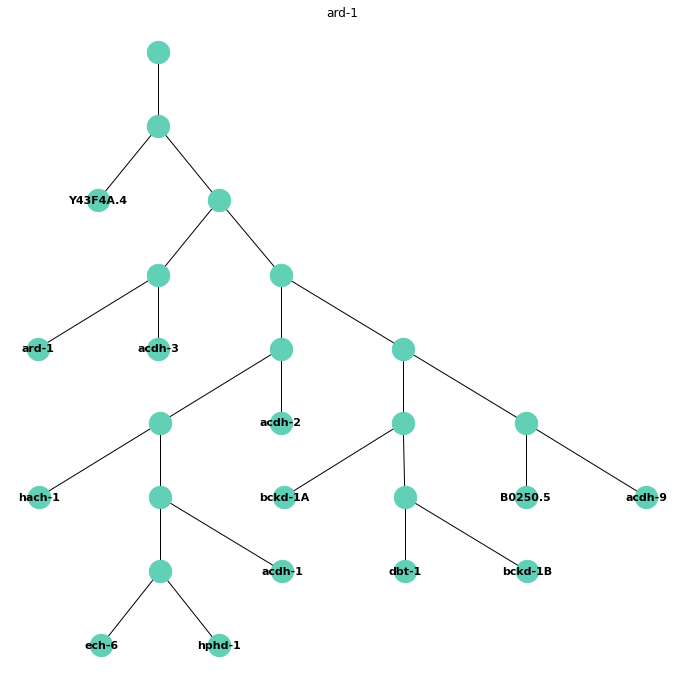

gene is bckd-1A
gene is hach-1
gene is ard-1
gene is acdh-2
gene is B0250.5
gene is Y43F4A.4
gene is ech-6
gene is hphd-1
gene is dbt-1
gene is acdh-1
gene is acdh-3
gene is acdh-9
gene is bckd-1B
gene list is ['bckd-1A', 'hach-1', 'ard-1', 'acdh-2', 'B0250.5', 'Y43F4A.4', 'ech-6', 'hphd-1', 'dbt-1', 'acdh-1', 'acdh-3', 'acdh-9', 'bckd-1B']


<Figure size 144x144 with 0 Axes>

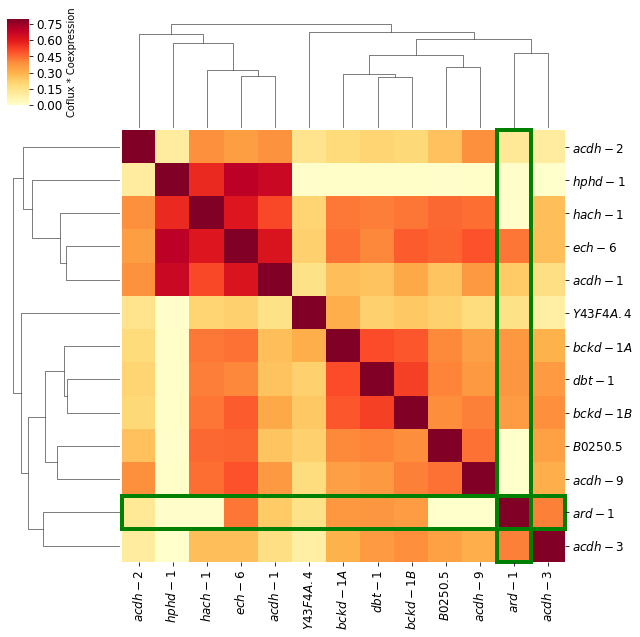

In [70]:
clustersheatmap(genename='ard-1',deepSplit=3,minClusterSize=6,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['chdh-1', 'cbs-2', 'adk-1', 'T13G4.4', 'mtrr-1', 'mthf-1', 'pmt-2',
       'sams-4', 'ahcy-1', 'sams-5', 'dph-5', 'pmt-1', 'sams-3', 'metr-1',
       'sams-1'],
      dtype='object')


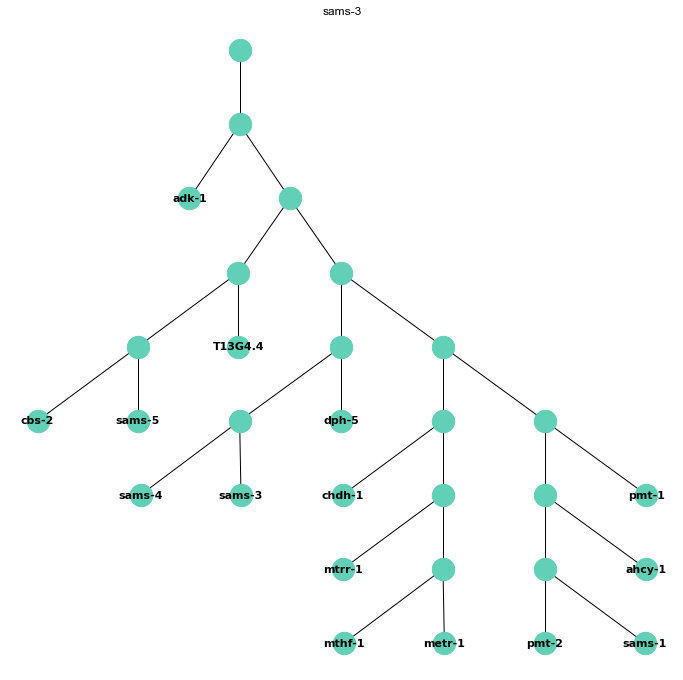

gene is chdh-1
gene is cbs-2
gene is adk-1
gene is T13G4.4
gene is mtrr-1
gene is mthf-1
gene is pmt-2
gene is sams-4
gene is ahcy-1
gene is sams-5
gene is dph-5
gene is pmt-1
gene is sams-3
gene is metr-1
gene is sams-1
gene list is ['chdh-1', 'cbs-2', 'adk-1', 'T13G4.4', 'mtrr-1', 'mthf-1', 'pmt-2', 'sams-4', 'ahcy-1', 'sams-5', 'dph-5', 'pmt-1', 'sams-3', 'metr-1', 'sams-1']


<Figure size 144x144 with 0 Axes>

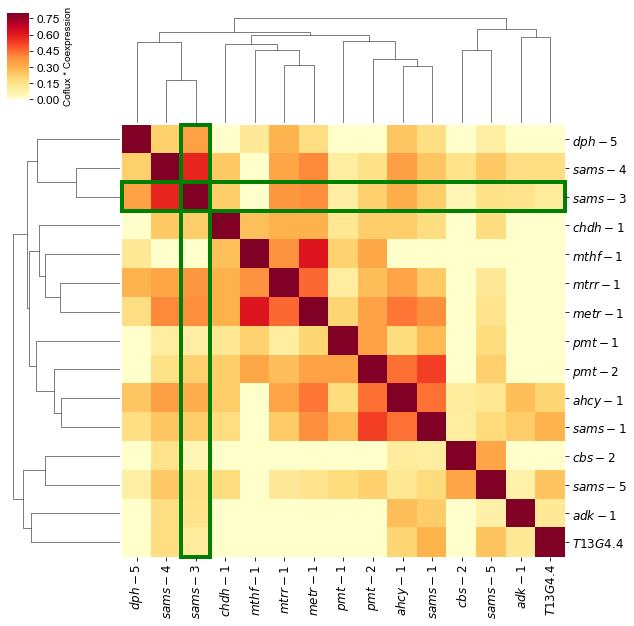

In [71]:
clustersheatmap(genename='sams-3',deepSplit=3,minClusterSize=6,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['sams-4', 'dph-5', 'sams-3'], dtype='object')


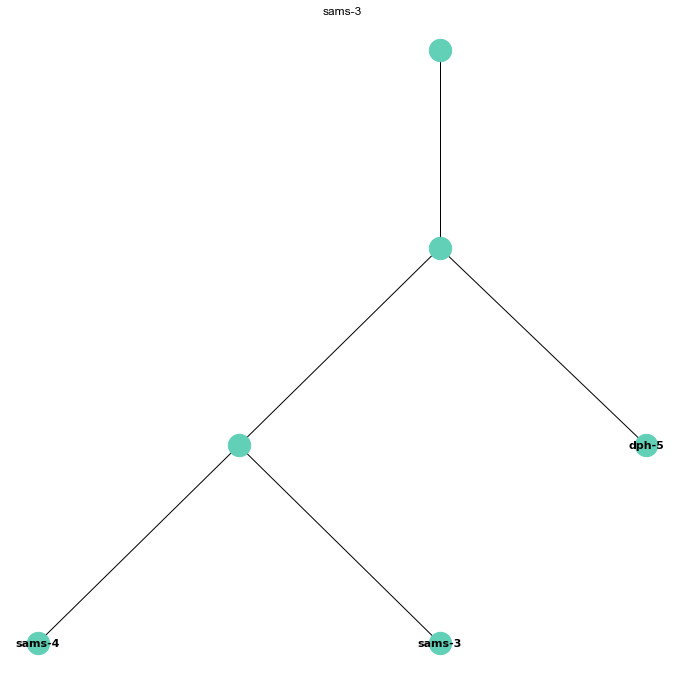

gene is sams-4
gene is dph-5
gene is sams-3
gene list is ['sams-4', 'dph-5', 'sams-3']


<Figure size 144x144 with 0 Axes>

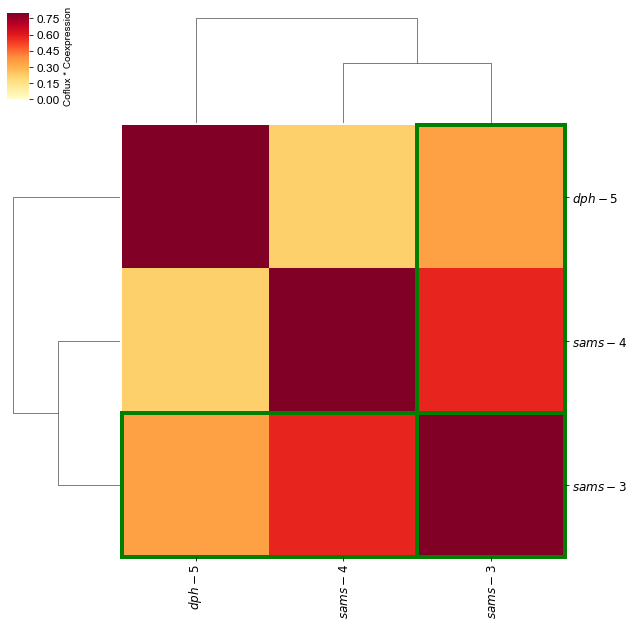

In [72]:
clustersheatmap(genename='sams-3',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['adk-1', 'pmt-2', 'ahcy-1', 'pmt-1', 'sams-1'], dtype='object')


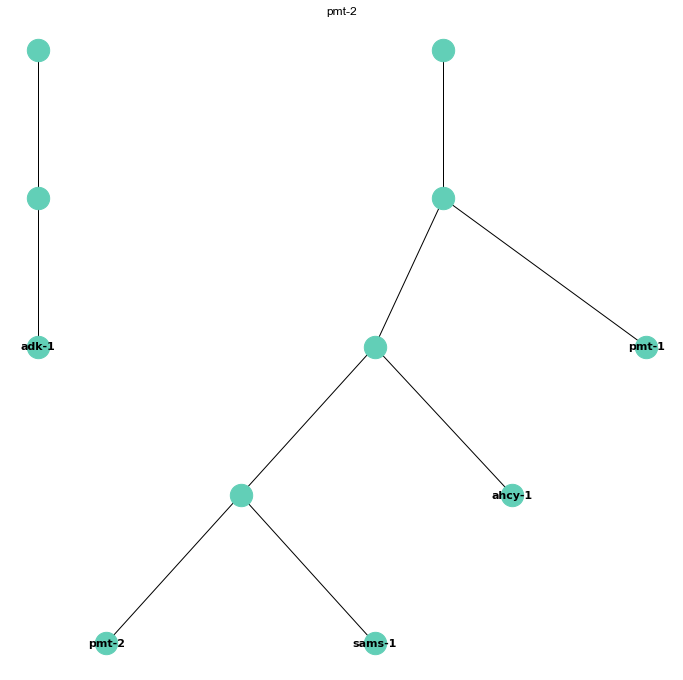

gene is adk-1
gene is pmt-2
gene is ahcy-1
gene is pmt-1
gene is sams-1
gene list is ['adk-1', 'pmt-2', 'ahcy-1', 'pmt-1', 'sams-1']


<Figure size 144x144 with 0 Axes>

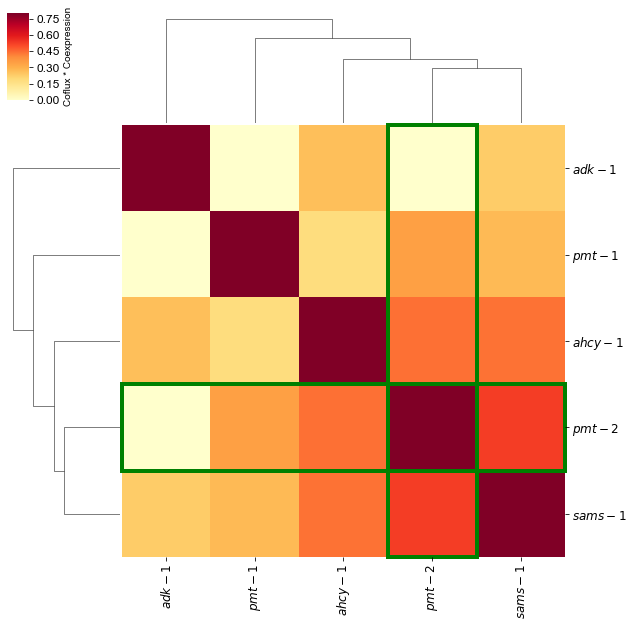

In [73]:
clustersheatmap(genename='pmt-2',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['adk-1', 'pmt-2', 'ahcy-1', 'pmt-1', 'sams-1'], dtype='object')


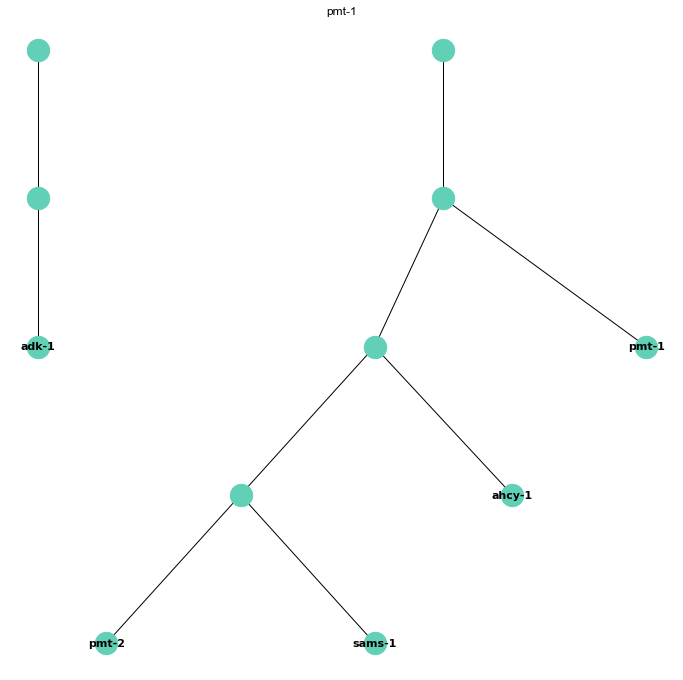

gene is adk-1
gene is pmt-2
gene is ahcy-1
gene is pmt-1
gene is sams-1
gene list is ['adk-1', 'pmt-2', 'ahcy-1', 'pmt-1', 'sams-1']


<Figure size 144x144 with 0 Axes>

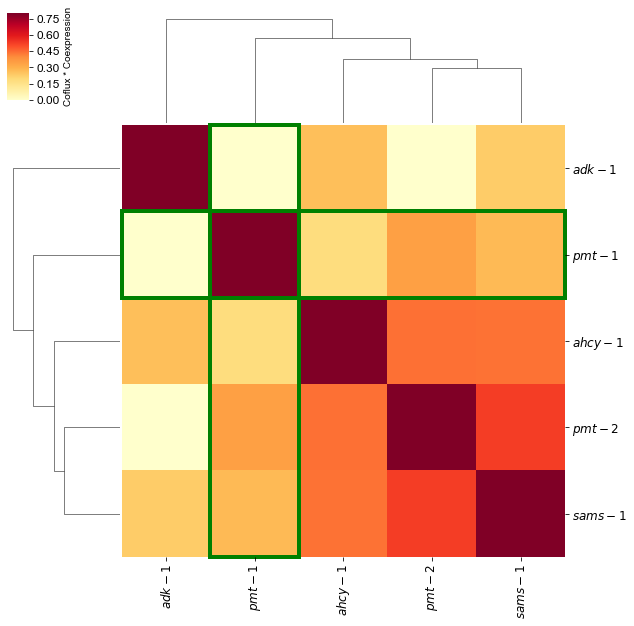

In [74]:
clustersheatmap(genename='pmt-1',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['chdh-1', 'mtrr-1', 'mthf-1', 'metr-1'], dtype='object')


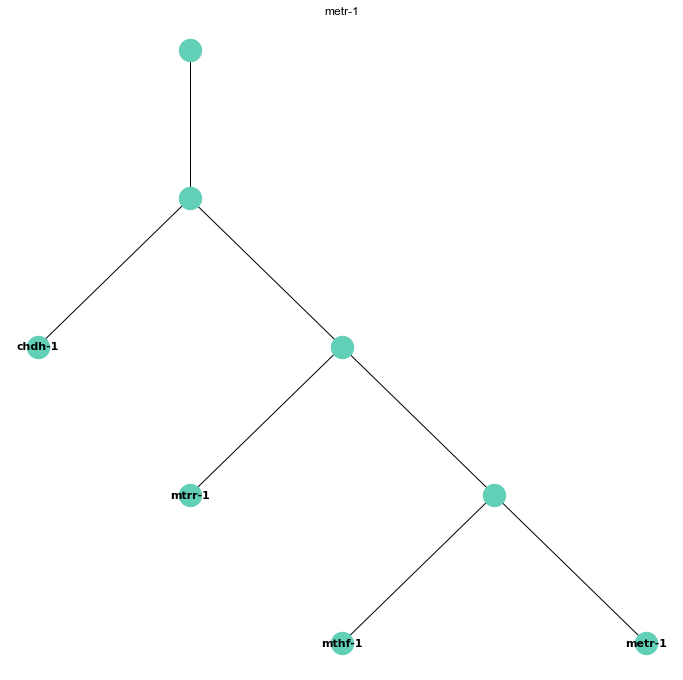

gene is chdh-1
gene is mtrr-1
gene is mthf-1
gene is metr-1
gene list is ['chdh-1', 'mtrr-1', 'mthf-1', 'metr-1']


<Figure size 144x144 with 0 Axes>

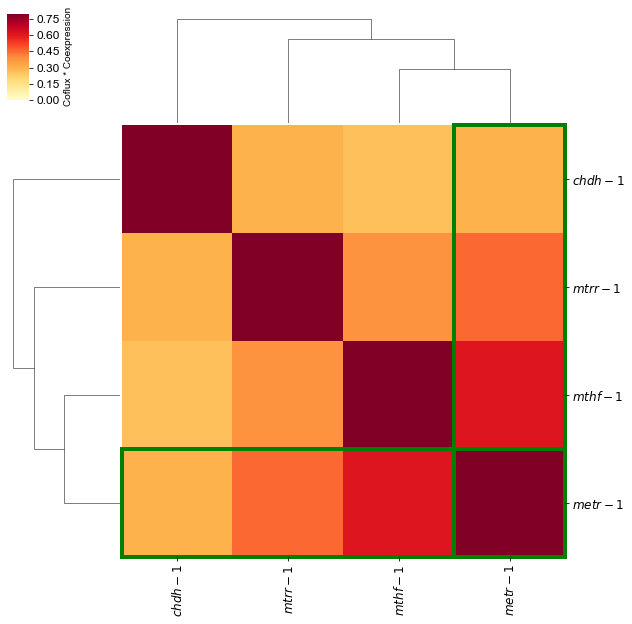

In [75]:
clustersheatmap(genename='metr-1',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['cth-2', 'cth-1', 'cbs-1', 'cbl-1'], dtype='object')


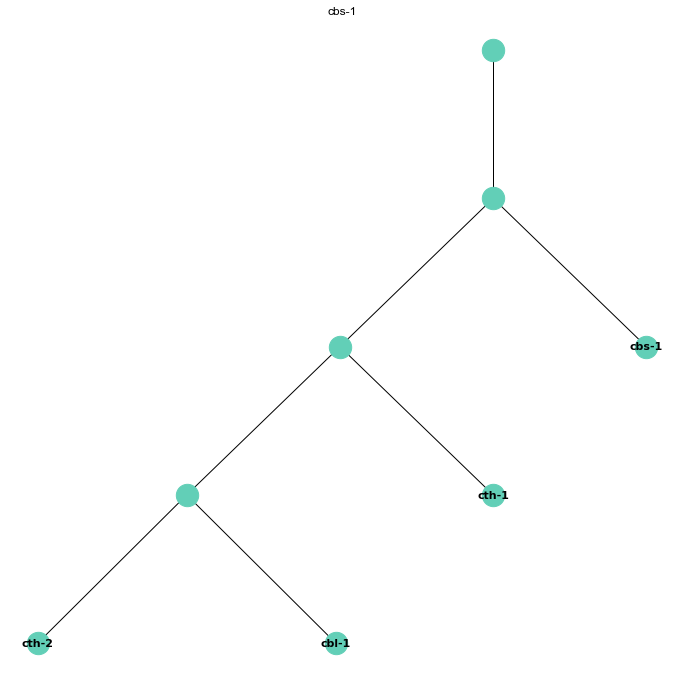

gene is cth-2
gene is cth-1
gene is cbs-1
gene is cbl-1
gene list is ['cth-2', 'cth-1', 'cbs-1', 'cbl-1']


<Figure size 144x144 with 0 Axes>

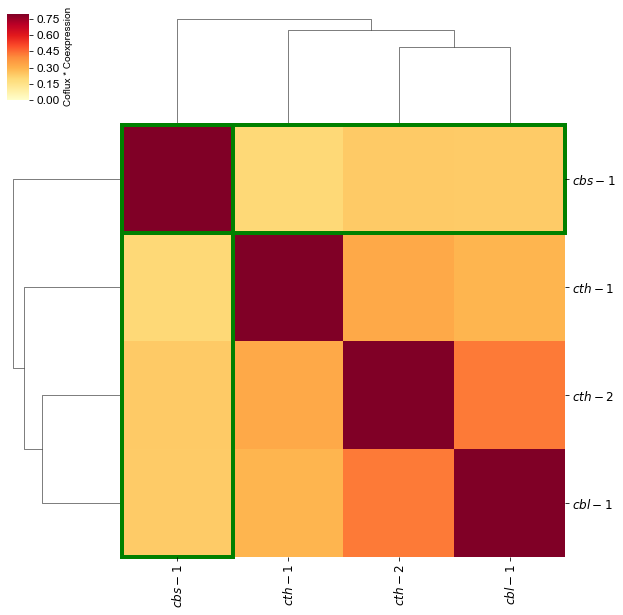

In [76]:
clustersheatmap(genename='cbs-1',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['cbs-2', 'T13G4.4', 'sams-5'], dtype='object')


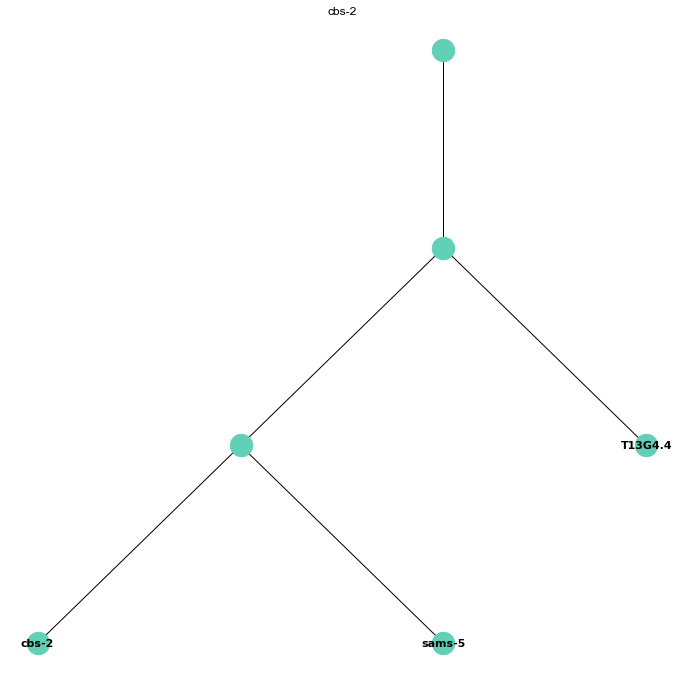

gene is cbs-2
gene is T13G4.4
gene is sams-5
gene list is ['cbs-2', 'T13G4.4', 'sams-5']


<Figure size 144x144 with 0 Axes>

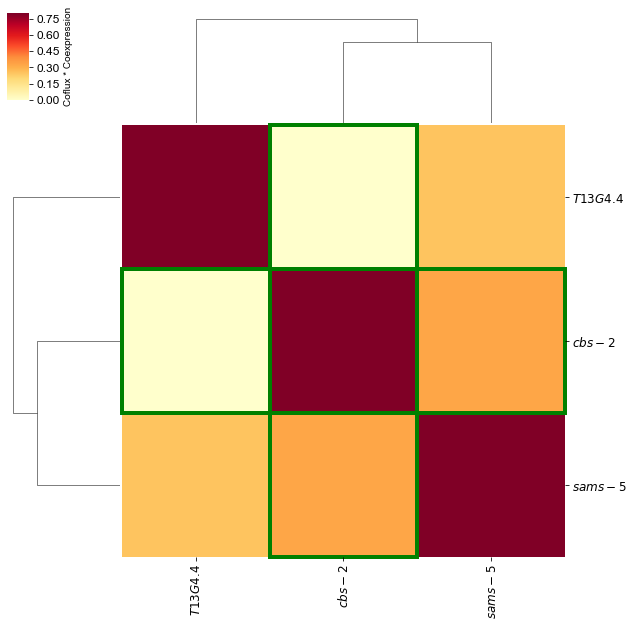

In [77]:
clustersheatmap(genename='cbs-2',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['cbs-2', 'T13G4.4', 'sams-5'], dtype='object')


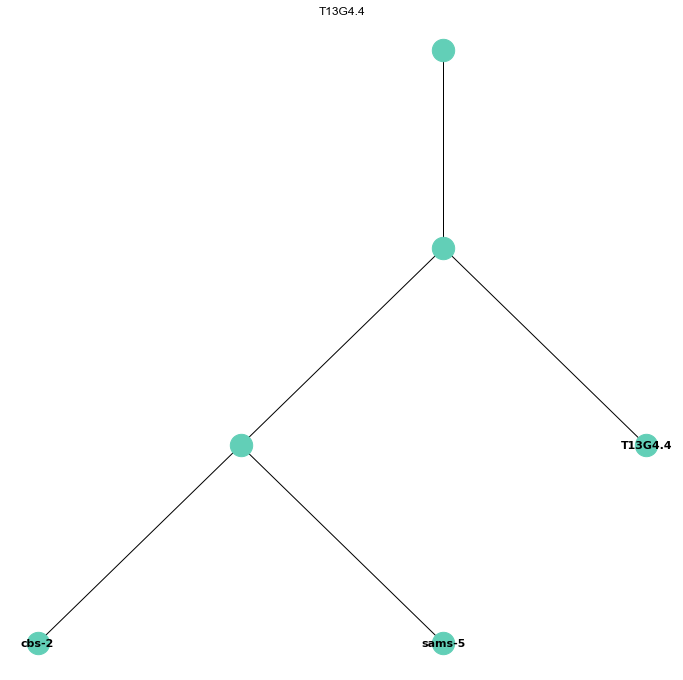

gene is cbs-2
gene is T13G4.4
gene is sams-5
gene list is ['cbs-2', 'T13G4.4', 'sams-5']


<Figure size 144x144 with 0 Axes>

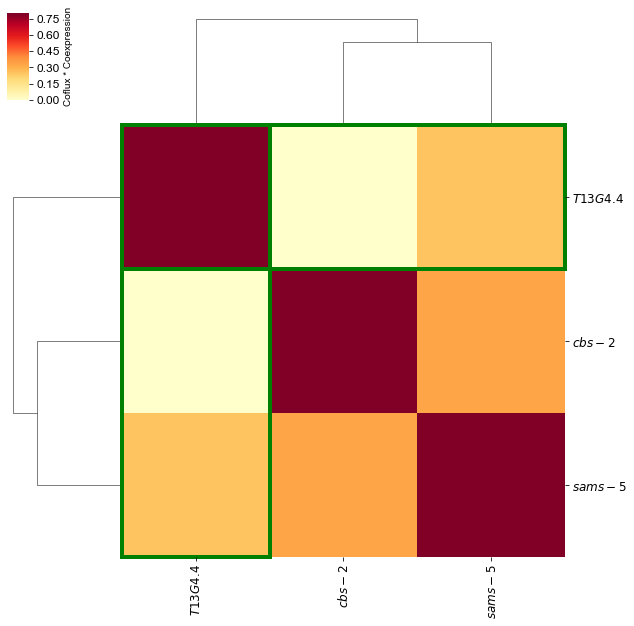

In [78]:
clustersheatmap(genename='T13G4.4',deepSplit=2,minClusterSize=3,matrix=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
outside : (1314, 1314) 
inside : (1314, 1314) 
Index(['alh-12', 'argk-1', 'F32B5.1', 'cpin-1', 'cth-2', 'asp-3', 'bas-1',
       'anmt-3', 'cth-1', 'haly-1', 'cbs-1', 'amdh-1', 'W10C8.5', 'bcat-1',
       'anmt-1', 'R102.4', 'acsd-1', 'haao-1', 'cbl-1', 'Y51H4A.7', 'asp-1',
       'ZC434.8', 'K12H4.7', 'asp-2', 'Y44A6D.5', 'asp-5'],
      dtype='object')


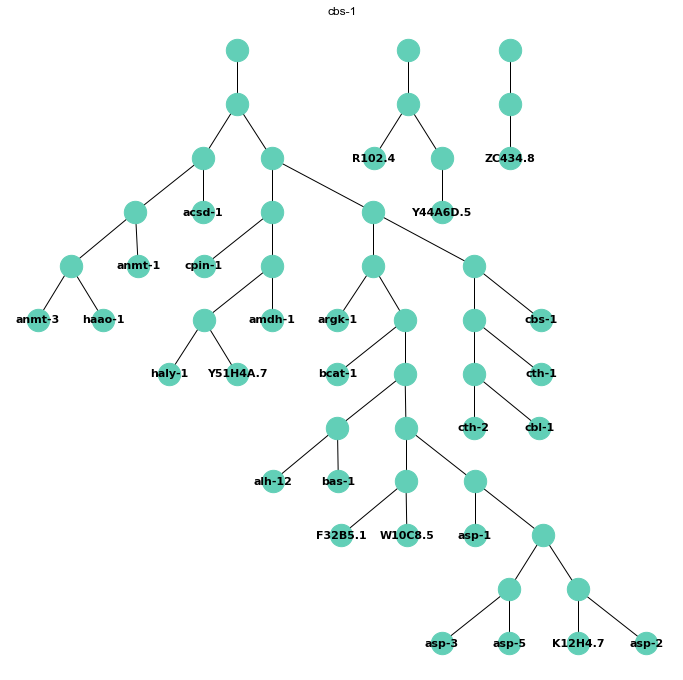

gene is alh-12
gene is argk-1
gene is F32B5.1
gene is cpin-1
gene is cth-2
gene is asp-3
gene is bas-1
gene is anmt-3
gene is cth-1
gene is haly-1
gene is cbs-1
gene is amdh-1
gene is W10C8.5
gene is bcat-1
gene is anmt-1
gene is R102.4
gene is acsd-1
gene is haao-1
gene is cbl-1
gene is Y51H4A.7
gene is asp-1
gene is ZC434.8
gene is K12H4.7
gene is asp-2
gene is Y44A6D.5
gene is asp-5
gene list is ['alh-12', 'argk-1', 'F32B5.1', 'cpin-1', 'cth-2', 'asp-3', 'bas-1', 'anmt-3', 'cth-1', 'haly-1', 'cbs-1', 'amdh-1', 'W10C8.5', 'bcat-1', 'anmt-1', 'R102.4', 'acsd-1', 'haao-1', 'cbl-1', 'Y51H4A.7', 'asp-1', 'ZC434.8', 'K12H4.7', 'asp-2', 'Y44A6D.5', 'asp-5']


<Figure size 144x144 with 0 Axes>

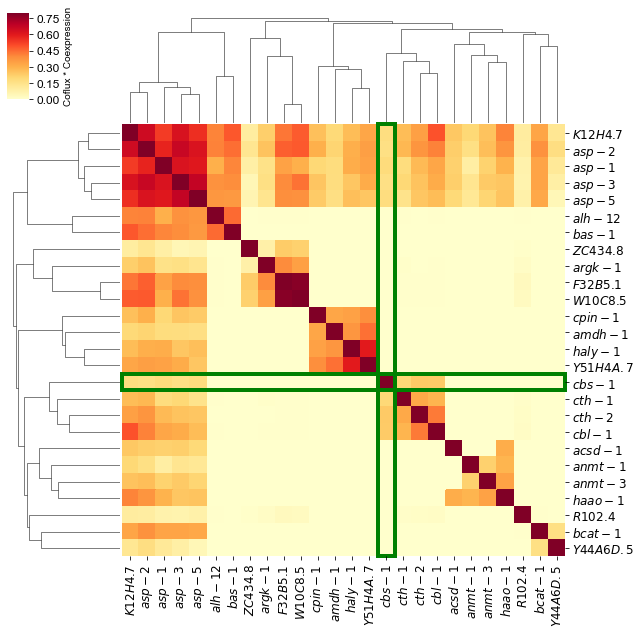

In [79]:
clustersheatmap(genename='cbs-1',deepSplit=3,minClusterSize=6,matrix=ProductMatrix)

In [80]:
# def CombinedClusterList(dee)

In [81]:
ProductMatrix=gene_to_wb(ProductMatrix)
FinalCoexp=gene_to_wb(FinalCoexp)
FinalFluxMatrix=gene_to_wb(FinalFluxMatrix)

In [82]:
ProductMatrix.to_csv("ProductMatrix_WB_062722.csv")

In [83]:
ProductMatrix=pd.read_csv("ProductMatrix_WB_062722.csv",index_col=0)

In [84]:
# ProductMatrix=wb_to_gene(ProductMatrix)

In [85]:
dist,link,clusters=calculate_dist_matrix(deepSplit=3,matrix=ProductMatrix,minClusterSize=6)
labels=clusters['labels']
ClusterList(clusters=clusters,output_df=ProductMatrix)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.
Number of genes in cluster 0 : 78
Number of genes in cluster 1 : 37
Number of genes in cluster 2 : 34
Number of genes in cluster 3 : 26
Number of genes in cluster 4 : 25
Number of genes in cluster 5 : 25
Number of genes in cluster 6 : 22
Number of genes in cluster 7 : 22
Number of genes in cluster 8 : 21
Number of genes in cluster 9 : 20
Number of genes in cluster 10 : 20
Number of genes in cluster 11 : 20
Number of genes in cluster 12 : 20
Number of genes in cluster 13 : 19
Number of genes in cluster 14 : 19
Number of genes in cluster 15 : 19
Number of genes in cluster 16 : 19
Number of genes in cluster 17 : 19
Number of genes in cluster 18 : 18
Number of genes in cluster 19 : 18
Number of genes in cluster 20 : 17
Number of genes in cluster 21 : 17
Number of genes in cluster 22 : 17
Number of genes in cluster 23 : 17
Number of genes in cluster 24 : 17
Number of genes i

## Finding list of genes in each cluster

In [86]:
Clusters=pd.DataFrame([])
matrix=ProductMatrix
Clusters['Genes']=matrix.index
Clusters['Cluster']=clusters['labels']
Cluster_list={}
labels=np.unique(clusters['labels'])
for label in labels:
    print(label)
    Cluster_list[label]=list(Clusters[Clusters.Cluster==label]['Genes']);
Cluster_list=pd.DataFrame.from_dict(Cluster_list,orient='index')
Cluster_list.reset_index(inplace=True)
Cluster_list.drop(columns=['index'],inplace=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [233]:
# ProductMatrix=wb_to_gene(ProductMatrix)
# FinalCoexp=wb_to_gene(FinalCoexp)
# FinalFluxMatrix=wb_to_gene(FinalFluxMatrix)

In [234]:
# ProductMatrix=gene_to_wb(ProductMatrix)

In [235]:
# ProductMatrix=wb_to_gene(ProductMatrix)

In [236]:
# ProductMatrix.loc['R05D11.9'].sort_values()

In [237]:
# ProductMatrix=wb_to_gene(ProductMatrix)
# clustersheatmap(genename='acdh-1',deepSplit=1,minClusterSize=3,matrix=ProductMatrix)

In [87]:
deepSplit=3
minClusterSize=6
for index in Cluster_list.index:
    FinalCluster=pd.DataFrame([])
#     index=49
    print(index)
    genes=list((Cluster_list.loc[index]).dropna())
    print(genes)
    ProductCluster=ProductMatrix.loc[genes][genes]
    CoexpCluster=FinalCoexp.loc[genes][genes]
    CofluxCluster=FinalFluxMatrix.loc[genes][genes]
    for i in CoexpCluster.index:
        for j in CoexpCluster.columns:
#             print("{}{}".format(i,j))
#             print(j)
            FinalCluster.at[i,j]=str(CofluxCluster.loc[i][j])+"_"+str(CoexpCluster.loc[i][j])+"_"+str(ProductCluster.loc[i][j])
#     FinalCluster=gene_to_wb(FinalCluster)
    FinalCluster.to_csv("/data/nandas/WormClust/product/product{}_{}_{}.csv".format(index,minClusterSize,deepSplit))
#     break;
#     print(ProductCluster)
#     break;

0
['WBGene00006600', 'WBGene00001503', 'WBGene00001130', 'WBGene00018424', 'WBGene00017777', 'WBGene00008548', 'WBGene00000090', 'WBGene00000240', 'WBGene00008131', 'WBGene00006729', 'WBGene00022456', 'WBGene00017103', 'WBGene00019465', 'WBGene00008127', 'WBGene00008581', 'WBGene00018771', 'WBGene00007886', 'WBGene00019604', 'WBGene00014027', 'WBGene00007089', 'WBGene00000296', 'WBGene00000913', 'WBGene00000001', 'WBGene00020397', 'WBGene00017565', 'WBGene00000038', 'WBGene00008230', 'WBGene00004092', 'WBGene00012983', 'WBGene00019151', 'WBGene00009554', 'WBGene00012326', 'WBGene00016632', 'WBGene00022250', 'WBGene00009635', 'WBGene00020398', 'WBGene00019295', 'WBGene00001093', 'WBGene00000035', 'WBGene00009126', 'WBGene00000295', 'WBGene00021787', 'WBGene00010397', 'WBGene00021043', 'WBGene00013597', 'WBGene00017818', 'WBGene00018286', 'WBGene00001262', 'WBGene00011232', 'WBGene00000041', 'WBGene00003234', 'WBGene00000481', 'WBGene00003778', 'WBGene00020765', 'WBGene00015270', 'WBGene

['WBGene00020182', 'WBGene00007455', 'WBGene00008583', 'WBGene00013904', 'WBGene00019515', 'WBGene00010904', 'WBGene00015141', 'WBGene00007885', 'WBGene00007402', 'WBGene00007422', 'WBGene00015577', 'WBGene00008486', 'WBGene00011006', 'WBGene00007650', 'WBGene00015739', 'WBGene00020592', 'WBGene00007073', 'WBGene00008485', 'WBGene00019516']
18
['WBGene00021252', 'WBGene00010160', 'WBGene00011162', 'WBGene00020407', 'WBGene00011757', 'WBGene00011166', 'WBGene00020270', 'WBGene00000497', 'WBGene00011163', 'WBGene00011164', 'WBGene00007425', 'WBGene00044807', 'WBGene00019867', 'WBGene00021057', 'WBGene00011167', 'WBGene00010945', 'WBGene00000503', 'WBGene00011846']
19
['WBGene00020256', 'WBGene00022200', 'WBGene00044468', 'WBGene00009057', 'WBGene00007812', 'WBGene00011398', 'WBGene00020258', 'WBGene00011423', 'WBGene00007753', 'WBGene00008776', 'WBGene00007755', 'WBGene00007419', 'WBGene00020446', 'WBGene00000081', 'WBGene00012911', 'WBGene00008749', 'WBGene00013575', 'WBGene00020195']
2

['WBGene00000392', 'WBGene00013690', 'WBGene00004392', 'WBGene00012423', 'WBGene00020190', 'WBGene00001683', 'WBGene00014034', 'WBGene00017775', 'WBGene00020557', 'WBGene00004391', 'WBGene00001686']
48
['WBGene00000115', 'WBGene00014098', 'WBGene00007824', 'WBGene00020950', 'WBGene00010052', 'WBGene00020679', 'WBGene00011510', 'WBGene00010794', 'WBGene00019819', 'WBGene00009082', 'WBGene00015413']
49
['WBGene00016810', 'WBGene00005022', 'WBGene00001793', 'WBGene00011050', 'WBGene00011409', 'WBGene00005019', 'WBGene00020696', 'WBGene00006863', 'WBGene00010665', 'WBGene00019890', 'WBGene00012020']
50
['WBGene00021553', 'WBGene00015332', 'WBGene00006562', 'WBGene00016419', 'WBGene00010661', 'WBGene00009001', 'WBGene00008669', 'WBGene00015334', 'WBGene00022849', 'WBGene00006541', 'WBGene00022231']
51
['WBGene00044903', 'WBGene00007745', 'WBGene00003816', 'WBGene00019813', 'WBGene00001646', 'WBGene00001604', 'WBGene00015464', 'WBGene00010166', 'WBGene00013362', 'WBGene00000266', 'WBGene0001

In [239]:
# ProductMatrix.drop(columns=['Silhoutte_Score','Cluster'],inplace=True)

In [240]:
# !mkdir /data/nandas/WormClust/Product

In [241]:
# !ls -lhrt /data/nandas/WormClust/Product/

In [242]:
# GeneList_5_3=[]
# for genename in ProductMatrix.index:
#     try:
#         clustersheatmap(genename=genename,deepSplit=3,minClusterSize=5,matrix=ProductMatrix)
#     except:
#         GeneList_5_3.append(genename)
#         print(GeneList_5_3)
#         pass
  

In [243]:
# GeneList_5_3=pd.DataFrame(GeneList_5_3)
# GeneList_5_3.to_csv("GenesInvalidFor5_3.csv")

In [88]:
FinalCoexp.replace(np.nan,0,inplace=True)
FinalCoexp.replace(np.inf,0,inplace=True)

In [89]:
ProductMatrix.replace(np.nan,0,inplace=True)
ProductMatrix.replace(np.inf,0,inplace=True)

In [246]:
# ProductMatrix.drop(columns=['Silhoutte_Score', 'Cluster'],inplace=True)

In [247]:
# ProductMatrix=pd.read_csv("ProductMatrix_062722.csv",index_col=0)

In [90]:
np.fill_diagonal(ProductMatrix.values,1)

In [91]:
ProductMatrix=wb_to_gene(ProductMatrix)

In [92]:
dist,link,clusters=calculate_dist_matrix(deepSplit=3,matrix=ProductMatrix,minClusterSize=6)

..cutHeight not given, setting it to 0.9938341999997924  ===>  99% of the (truncated) height range in dendro.
..done.


In [93]:
FinalCoexp.index=FinalCoexp.index.str.strip()

In [94]:
FinalCoexp=FinalCoexp.transpose()

In [95]:
FinalCoexp

,WBGene00001794,WBGene00006592,WBGene00004089,WBGene00007472,WBGene00020256,WBGene00004023,WBGene00020517,WBGene00009628,WBGene00003411,WBGene00007480,...,WBGene00010336,WBGene00016704,WBGene00019516,WBGene00000108,WBGene00009531,WBGene00015413,WBGene00004248,WBGene00020181,WBGene00009146,WBGene00001479
WBGene00001794,1.000000,0.358714,0.059578,0.099954,0.377728,0.216362,0.372356,0.337838,0.224996,0.248140,...,0.319800,0.035356,0.254434,0.057206,0.419590,0.269264,0.032594,0.330230,0.246064,0.299972
WBGene00006592,0.358714,1.000000,0.166374,0.067068,0.266918,0.248736,0.201782,0.333818,0.296808,0.309844,...,0.355420,0.247708,0.300258,0.024334,0.254750,0.158948,0.092368,0.180254,0.184112,0.419338
WBGene00004089,0.059578,0.166374,1.000000,0.072320,0.068486,0.090602,0.170674,0.080640,0.292172,0.096410,...,0.120762,0.399812,0.142276,0.061158,0.058418,0.158308,0.201124,0.024300,0.054014,0.089966
WBGene00007472,0.099954,0.067068,0.072320,1.000000,0.085202,0.081212,0.081814,0.042216,0.031860,0.287550,...,0.067586,0.000000,0.102906,0.226924,0.112002,0.019578,0.046294,0.082314,0.169866,0.031912
WBGene00020256,0.377728,0.266918,0.068486,0.085202,1.000000,0.173838,0.296870,0.266588,0.121022,0.337856,...,0.290594,0.023674,0.182378,0.025598,0.273282,0.217252,0.021318,0.225712,0.315814,0.255170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00015413,0.269264,0.158948,0.158308,0.019578,0.217252,0.066442,0.396816,0.212706,0.140128,0.074740,...,0.059028,0.190486,0.052080,0.021114,0.283362,1.000000,0.213726,0.368038,0.159576,0.105876
WBGene00004248,0.032594,0.092368,0.201124,0.046294,0.021318,0.000000,0.182482,0.010224,0.106894,0.000000,...,0.054804,0.138480,0.012050,0.057188,0.000000,0.213726,1.000000,0.237564,0.000000,0.000000
WBGene00020181,0.330230,0.180254,0.024300,0.082314,0.225712,0.142954,0.499882,0.212694,0.083310,0.076046,...,0.162802,0.067240,0.086072,0.079610,0.333830,0.368038,0.237564,1.000000,0.142820,0.140224
WBGene00009146,0.246064,0.184112,0.054014,0.169866,0.315814,0.230928,0.153274,0.176596,0.094492,0.239616,...,0.171018,0.033938,0.117868,0.116278,0.234316,0.159576,0.000000,0.142820,1.000000,0.119754


In [96]:
labels=clusters['labels']

In [97]:
len(labels)

1314

In [98]:
Number_of_clusters=np.unique(clusters['labels'])

In [99]:
ClusterList(clusters=clusters,output_df=ProductMatrix)

Number of genes in cluster 0 : 78
Number of genes in cluster 1 : 37
Number of genes in cluster 2 : 34
Number of genes in cluster 3 : 26
Number of genes in cluster 4 : 25
Number of genes in cluster 5 : 25
Number of genes in cluster 6 : 22
Number of genes in cluster 7 : 22
Number of genes in cluster 8 : 21
Number of genes in cluster 9 : 20
Number of genes in cluster 10 : 20
Number of genes in cluster 11 : 20
Number of genes in cluster 12 : 20
Number of genes in cluster 13 : 19
Number of genes in cluster 14 : 19
Number of genes in cluster 15 : 19
Number of genes in cluster 16 : 19
Number of genes in cluster 17 : 19
Number of genes in cluster 18 : 18
Number of genes in cluster 19 : 18
Number of genes in cluster 20 : 17
Number of genes in cluster 21 : 17
Number of genes in cluster 22 : 17
Number of genes in cluster 23 : 17
Number of genes in cluster 24 : 17
Number of genes in cluster 25 : 16
Number of genes in cluster 26 : 16
Number of genes in cluster 27 : 15
Number of genes in cluster 28 

In [100]:
Number_of_clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

In [101]:
clusters

{'labels': array([10, 28, 45, ...,  2, 76, 95]),
 'cores': array([10,  0, 45, ...,  2, 76, 95]),
 'smallLabels': array([  0, 261,   0, ...,   0,   0,   0]),
 'onBranch': array([  0, 334,   0, ...,   0,   0,   0]),
 'mergeDiagnostics': {'smI': array([nan, nan, nan, ..., nan, nan, nan]),
  'smSize': array([nan, nan, nan, ..., nan, nan, nan]),
  'smCrSc': array([nan, nan, nan, ..., nan, nan, nan]),
  'smGap': array([nan, nan, nan, ..., nan, nan, nan]),
  'lgI': array([nan, nan, nan, ..., nan, nan, nan]),
  'lgSize': array([nan, nan, nan, ..., nan, nan, nan]),
  'lgCrSc': array([nan, nan, nan, ..., nan, nan, nan]),
  'lgGap': array([nan, nan, nan, ..., nan, nan, nan]),
  'merged': array([nan, nan, nan, ..., nan, nan, nan])},
 'mergeCriteria': {'maxCoreScatter': 0.91,
  'minGap': 0.06749999999999998,
  'maxAbsCoreScatter': 0.9388969219998111,
  'minAbsGap': 0.04120295849998597,
  'minExternalSplit': None},
 'branches': {'nBranches': 509,
  'IndMergeToBranch': array([1, 2, 3, ..., 0, 0, 0]),

In [102]:
(clusters['labels']==0)

array([False, False, False, ..., False, False, False])

In [103]:
Clusters=pd.DataFrame([])
Clusters['Genes']=ProductMatrix.index
Clusters['Cluster']=clusters['labels']

In [104]:
Cluster_list={}
labels=np.unique(clusters['labels'])

In [105]:
for label in labels:
    print(label)
    Cluster_list[label]=list(Clusters[Clusters.Cluster==label]['Genes']);
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [106]:
Cluster_list=pd.DataFrame.from_dict(Cluster_list,orient='index')


In [107]:
Cluster_list.reset_index(inplace=True)

In [108]:
Cluster_list

,index,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,76,77
0,0,tph-1,fum-1,dyn-1,pgph-2,F25B5.6,F07A11.5,age-1,pah-1,C47B2.2,...,F19B6.1,eat-3,shpk-1,T05H4.4,Y19D10A.16,daao-1,aco-1,ace-2,pgph-3,pus-1
1,1,gcy-20,gcy-21,gcy-32,gcy-37,gcy-29,gcy-15,pde-1,pde-3,pde-5,...,None,None,None,None,None,None,None,None,None,None
2,2,cox-7C,cox-5A,Y106G6E.4,C16A3.5,prdx-2,Y71H2AM.4,F45H10.3,mccc-1,F32D8.12,...,None,None,None,None,None,None,None,None,None,None
3,3,alh-12,argk-1,F32B5.1,cpin-1,cth-2,asp-3,bas-1,anmt-3,cth-1,...,None,None,None,None,None,None,None,None,None,None
4,4,met-2,set-11,set-33,met-1,gbh-2,set-2,set-16,set-6,jhdm-1,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,chup-1,dhs-25,F53F1.3,Y39G8B.2,F53F1.2,C07D8.6,None,None,None,...,None,None,None,None,None,None,None,None,None,None
94,94,ugt-18,R05G6.5,ugt-56,ugt-55,ugt-59,ugt-15,None,None,None,...,None,None,None,None,None,None,None,None,None,None
95,95,fmo-3,fmo-2,fmo-5,fmo-1,argn-1,fmo-4,None,None,None,...,None,None,None,None,None,None,None,None,None,None
96,96,bgal-1,hex-1,hex-5,bgal-2,gana-1,cgt-2,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [109]:
for i in Cluster_list.index:
    print(i)
    Cluster_list.at[i,'labels']="{}".format(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [110]:
Cluster_list

,index,0,1,2,3,4,5,6,7,8,...,69,70,71,72,73,74,75,76,77,labels
0,0,tph-1,fum-1,dyn-1,pgph-2,F25B5.6,F07A11.5,age-1,pah-1,C47B2.2,...,eat-3,shpk-1,T05H4.4,Y19D10A.16,daao-1,aco-1,ace-2,pgph-3,pus-1,0
1,1,gcy-20,gcy-21,gcy-32,gcy-37,gcy-29,gcy-15,pde-1,pde-3,pde-5,...,None,None,None,None,None,None,None,None,None,1
2,2,cox-7C,cox-5A,Y106G6E.4,C16A3.5,prdx-2,Y71H2AM.4,F45H10.3,mccc-1,F32D8.12,...,None,None,None,None,None,None,None,None,None,2
3,3,alh-12,argk-1,F32B5.1,cpin-1,cth-2,asp-3,bas-1,anmt-3,cth-1,...,None,None,None,None,None,None,None,None,None,3
4,4,met-2,set-11,set-33,met-1,gbh-2,set-2,set-16,set-6,jhdm-1,...,None,None,None,None,None,None,None,None,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,chup-1,dhs-25,F53F1.3,Y39G8B.2,F53F1.2,C07D8.6,None,None,None,...,None,None,None,None,None,None,None,None,None,93
94,94,ugt-18,R05G6.5,ugt-56,ugt-55,ugt-59,ugt-15,None,None,None,...,None,None,None,None,None,None,None,None,None,94
95,95,fmo-3,fmo-2,fmo-5,fmo-1,argn-1,fmo-4,None,None,None,...,None,None,None,None,None,None,None,None,None,95
96,96,bgal-1,hex-1,hex-5,bgal-2,gana-1,cgt-2,None,None,None,...,None,None,None,None,None,None,None,None,None,96


In [121]:
# Cluster_list.set_index(['ClusterName'],inplace=True)

In [111]:
Cluster_list.drop(columns=['index'],inplace=True)

In [112]:
ClusterSize=pd.DataFrame(Cluster_list.notna().sum(axis=1))

In [113]:
ClusterSize.set_axis(['Cluster_size'],inplace=True,axis=1)

In [114]:
ClusterSize.sort_values(by=['Cluster_size'],inplace=True)

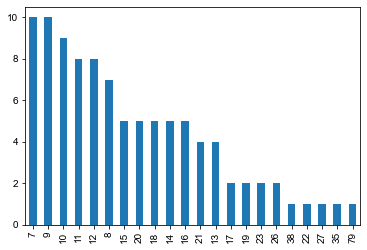

In [115]:
ClusterSize['Cluster_size'].value_counts().plot(kind='bar')
# plt.xticks(np.arange(0,65,5))
ClusterSize.to_csv("ClusterSize__3.csv")

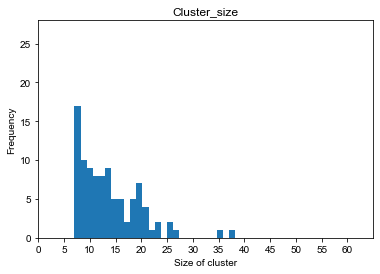

In [116]:
ClusterSize.hist(grid=False,bins=60)
plt.ylim(0,28)
plt.xlim(0,65)
plt.xlabel("Size of cluster")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,65,5))
plt.savefig("ClusterSizePlot.svg",dpi=300)
plt.savefig("ClusterSizePlot.png",dpi=300)

In [117]:
Cluster_list.to_csv("ProductMatrixClusterListFluxRed_6_3_062722.gmt",sep='\t')
Cluster_list.to_csv("ProductMatrixClusterListFluxRed_6_3_062722.csv",sep='\t')

In [118]:
Cluster_list

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,labels
0,tph-1,fum-1,dyn-1,pgph-2,F25B5.6,F07A11.5,age-1,pah-1,C47B2.2,ucp-4,...,eat-3,shpk-1,T05H4.4,Y19D10A.16,daao-1,aco-1,ace-2,pgph-3,pus-1,0
1,gcy-20,gcy-21,gcy-32,gcy-37,gcy-29,gcy-15,pde-1,pde-3,pde-5,gcy-19,...,None,None,None,None,None,None,None,None,None,1
2,cox-7C,cox-5A,Y106G6E.4,C16A3.5,prdx-2,Y71H2AM.4,F45H10.3,mccc-1,F32D8.12,T22D1.3,...,None,None,None,None,None,None,None,None,None,2
3,alh-12,argk-1,F32B5.1,cpin-1,cth-2,asp-3,bas-1,anmt-3,cth-1,haly-1,...,None,None,None,None,None,None,None,None,None,3
4,met-2,set-11,set-33,met-1,gbh-2,set-2,set-16,set-6,jhdm-1,set-23,...,None,None,None,None,None,None,None,None,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,chup-1,dhs-25,F53F1.3,Y39G8B.2,F53F1.2,C07D8.6,None,None,None,None,...,None,None,None,None,None,None,None,None,None,93
94,ugt-18,R05G6.5,ugt-56,ugt-55,ugt-59,ugt-15,None,None,None,None,...,None,None,None,None,None,None,None,None,None,94
95,fmo-3,fmo-2,fmo-5,fmo-1,argn-1,fmo-4,None,None,None,None,...,None,None,None,None,None,None,None,None,None,95
96,bgal-1,hex-1,hex-5,bgal-2,gana-1,cgt-2,None,None,None,None,...,None,None,None,None,None,None,None,None,None,96


In [130]:
# ProductMatrix.drop(columns=['Silhoutte_Score', 'Cluster'],inplace=True)

In [131]:
# ProductMatrix.drop(columns=['Silhoutte_Score','Cluster'],inplace=True)


In [132]:
# genedict=display_the_gene_in_respective_cluster_or_subtree(deepSplit=2,
#                                                            gene_name='acdh-1',
#                                                            matrix=ProductMatrix,
#                                                            minClusterSize=3)

In [133]:
# genelist=list()
# for key in genedict.keys():
#     print("key is {}".format(key))
#     gene=genedict[key]
#     print("gene is {}".format(gene))
#     genelist.append(gene)
#     print("gene list is {}".format(genelist))
    

### Function: `clustersheatmap`

**Description:** 
This function generates a heatmap for a specified gene and its associated cluster. It first identifies the cluster where the gene belongs and then creates a heatmap of the genes within that cluster.

**Parameters:**
- `genename`: The name of the gene of interest.
- `deepSplit`: Parameter for hierarchical clustering.
- `minClusterSize`: Minimum size of clusters to be considered.
- `matrix`: The gene matrix from which the clusters are derived.

**Functionality:**
1. Obtains a dictionary `genedict` mapping the genes to their respective clusters or subtrees using `display_the_gene_in_respective_cluster_or_subtree` function.
2. Extracts a list `genelist` of genes from the dictionary.
3. Prints the list of genes in the cluster associated with the specified gene.
4. Initializes a figure with specified dimensions.
5. Extracts a submatrix `aagr` from the main matrix, containing only the genes in the identified cluster.
6. Generates a clustermap (heatmap with hierarchical clustering) using seaborn's `clustermap` function. The heatmap displays the relationships between genes in the cluster with specific configurations (e.g., color map 'YlOrRd', value range from 0 to 0.8).
7. Saves the generated heatmap in both SVG and PNG formats with filenames based on the specified `genename`.

**Example Usage:**
```python
clustersheatmap(genename='example_gene', deepSplit=3, minClusterSize=6, matrix=your_matrix)


In [119]:

def clustersheatmap(genename,deepSplit,minClusterSize,matrix):
    genedict=display_the_gene_in_respective_cluster_or_subtree(deepSplit=deepSplit,gene_name=genename,
                                                               matrix=matrix,
                                                               minClusterSize=minClusterSize)
    genelist=list()
    for key in genedict.keys():
#         print("key is {}".format(key))
        gene=genedict[key]
        print("gene is {}".format(gene))
        genelist.append(gene)
    print("gene list is {}".format(genelist))
    fig=plt.figure(figsize=(2,2))
    aagr_cluster=genelist
    aagr=matrix.loc[aagr_cluster][aagr_cluster]
    sns.clustermap(aagr,method='average',cbar_kws={'label':'Coflux * Coexpression'},vmin=0,vmax=0.8,cmap='YlOrRd')
    plt.savefig("{}_cluster.svg".format(genename),dpi=600)
    plt.savefig("{}_cluster.png".format(genename),dpi=600)

## Silhouette scores of clusters

### Code Snippet Description

**Purpose:** 
This snippet demonstrates the calculation and integration of silhouette scores into a given dataframe. Silhouette scores are used to assess the separation distance between the resulting clusters.

**Process:**
1. Calculates silhouette scores for each sample in a dataset using the `SilhoutteSample` function.
2. Incorporates these scores into the `ProductMatrix` dataframe using the `Silhoutte_Values` function.




In [120]:
silhoutte_score_values=SilhoutteSample(dist=dist,labels=clusters['labels'],metric='precomputed')
Silhoutte_Val=Silhoutte_Values(output_df=ProductMatrix,labels=clusters['labels'],
                               silhouette_score_values=silhoutte_score_values)

In [137]:
# Silhoutte_Val=wb_to_gene(Silhoutte_Val)

### Find which cluster does propionate shunt fall in to test for positive control

In [121]:
Silhoutte_Val.loc['acdh-1']['Cluster']

37.0

### Code Snippet Description

**Purpose:** 
This snippet calculates the average silhouette score for a given set of clusters, providing a measure of how distinct the clusters are within the dataset.

**Process:**
1. Determines the number of unique clusters in the dataset.
2. Computes the average silhouette score across all clusters.


In [122]:
n_clusters=len(np.unique(clusters['labels']))
silhouette_avg = silhouette_score(dist, labels=clusters['labels'],metric='precomputed')


**Purpose:** 
This snippet filters the dataframe `Silhoutte_Val` to include only the rows corresponding to the same cluster as the sample labeled 'acdh-1'. This is useful for analyzing data from a dynamically determined cluster based on a specific sample.



In [123]:
y=Silhoutte_Val[Silhoutte_Val.Cluster==(Silhoutte_Val.loc['acdh-1']['Cluster'])]

In [124]:
y.index

Index(['bckd-1A', 'hach-1', 'ard-1', 'acdh-2', 'B0250.5', 'Y43F4A.4', 'ech-6',
       'hphd-1', 'dbt-1', 'acdh-1', 'acdh-3', 'acdh-9', 'bckd-1B'],
      dtype='object')

In [35]:
#z=Silhoutte_Val[Silhoutte_Val.Cluster==37]

In [36]:

#z

,Silhoutte_Score,Cluster
acdh-1,0.123225,37
ech-6,0.214415,37
bckd-1B,0.218209,37
bckd-1A,0.218799,37
acdh-3,0.141689,37
ard-1,0.062222,37
acdh-2,0.107576,37
hach-1,0.319135,37
dbt-1,0.219405,37
B0250.5,0.198522,37


In [125]:
y=y.loc[['acdh-1','ech-6','hach-1', 'hphd-1','bckd-1A','acdh-2' , 'ard-1', 'B0250.5', 'acdh-9', 
        'bckd-1B', 'dbt-1', 'Y43F4A.4' , 'acdh-3']]

In [126]:
Silhoutte_Val[Silhoutte_Val.Cluster==37].sort_values(by=['Silhoutte_Score'])

,Silhoutte_Score,Cluster
ard-1,0.062222,37
hphd-1,0.085058,37
acdh-2,0.107576,37
Y43F4A.4,0.115527,37
acdh-1,0.123225,37
acdh-3,0.141689,37
B0250.5,0.198522,37
ech-6,0.214415,37
bckd-1B,0.218209,37
bckd-1A,0.218799,37



**Purpose:** 
This snippet calculates the mean of the silhouette scores from a subset of the `Silhoutte_Val` dataframe. This subset (`y`) is defined by a specific cluster label, and the mean is computed for the silhouette scores within this cluster.



In [127]:
Mean_threshold=Silhoutte_Val.loc[y.index].Silhoutte_Score.mean()

In [128]:
Mean_threshold

0.1733652230270046


**Purpose:** 
This snippet creates a dataframe `Clusters` that contains the unique cluster labels from `clusters['labels']` and calculates the mean silhouette values for each cluster. It then computes the median of these mean silhouette values.

**Process:**
1. Initializes an empty dataframe `Clusters`.
2. Assigns unique cluster labels to `Clusters['labels']`.
3. Calculates the silhouette scores for each sample using `silhouette_samples`.
4. Iterates through each unique cluster label to calculate the mean silhouette value for that cluster and adds it to `Clusters`.
5. Calculates the median of the mean silhouette values across all clusters.



In [129]:
Clusters=pd.DataFrame([]);
Clusters['labels']=np.unique(clusters['labels']);
sample_silhouette_values = silhouette_samples(dist, labels=clusters['labels'], metric='precomputed')
for i in np.unique(clusters['labels']):
    x=np.mean(sample_silhouette_values[clusters['labels'] == i])
    Clusters.at[i,'Mean Silhoutte Values']=x
median=Clusters['Mean Silhoutte Values'].median()   


In [130]:
median

0.06909768146490453


**Purpose:** 
This snippet generates a scatter plot visualizing the silhouette scores of genes in a specific cluster (referred to as 'shunt cluster'). It also marks the mean silhouette score of this cluster and the median silhouette score of selected clusters for comparison.

**Process:**
1. Creates a figure with specified dimensions.
2. Plots a scatter graph of silhouette scores (`Silhoutte_Score`) for each gene in the 'shunt cluster'.
3. Draws horizontal lines to represent the mean silhouette score of the 'shunt cluster' and the median silhouette score of selected clusters.
4. Adds legends, labels, and other formatting details.
5. Saves the plot as an SVG file with transparent background.



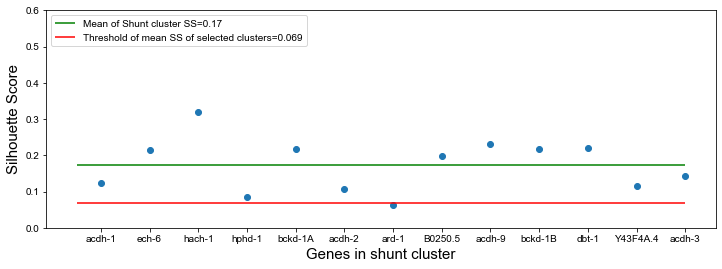

In [131]:
plt.figure(figsize=(12,4))
plt.scatter(y.index,y.Silhoutte_Score,vmin=0,vmax=0.8)
plt.hlines(Mean_threshold,xmin=-0.5,xmax=12,color='green',label='Mean of Shunt cluster SS=0.17')
plt.hlines(median,xmin=-0.5,xmax=12,color='red',label='Threshold of mean SS of selected clusters=0.069')
plt.legend(loc='upper left')
plt.xlabel("Genes in shunt cluster",fontsize=15)
plt.ylabel("Silhouette Score",fontsize=15)
plt.ylim(0,0.6)
plt.rcParams["font.family"] = "Arial"
# plt.title("Plot showing Silhouette scores(SS) of cluster \ncontaining shunt genes",fontsize=18)
plt.savefig("Shunt_Genes_SS_{}_{}.svg".format(minClusterSize,deepSplit),dpi=600,transparent=True)

This snippet generates a histogram to visualize the distribution of silhouette scores for genes based on their placement in clusters. It also marks a threshold line representing the median silhouette score of the clusters.

**Process:**
1. Sets up a figure with specified dimensions.
2. Creates a histogram of the silhouette scores from `Silhoutte_Val` dataframe.
3. Configures the histogram settings, such as the number of bins and grid visibility.
4. Adds labels to the x-axis and y-axis, and a title to the plot.
5. Draws a vertical line representing the median silhouette score of clusters and adds a legend.
6. Sets the font style for the plot.



Text(0.5, 1.0, 'Distribution of Silhoutte scores of genes \nas per their placement in clusters')

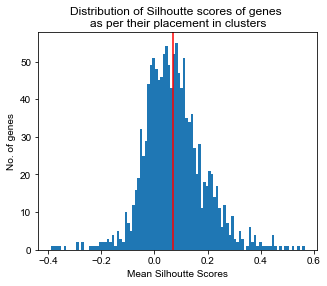

In [132]:
plt.figure(figsize=(5,4))
Silhoutte_Val.Silhoutte_Score.hist(bins=100,grid=False)
plt.xlabel("Mean Silhoutte Scores")
plt.ylabel("No. of genes")
plt.axvline(x=median,color='red',label='Threshold of MSS of clusters=0.069')
plt.rcParams["font.family"] = "Arial"
plt.title("Distribution of Silhoutte scores of genes \nas per their placement in clusters")

### Code Snippet Description

**Purpose:** 
This snippet creates a histogram to visualize the distribution of mean silhouette scores across different clusters. It also marks a threshold line representing the median of these mean silhouette scores.

**Process:**
1. Sets up a figure with specified dimensions.
2. Draws a vertical line to represent the median mean silhouette score of the selected clusters.
3. Creates a histogram for the mean silhouette values of the clusters from the `Clusters` dataframe.
4. Configures the histogram settings, such as density, number of bins, and grid visibility.
5. Adds labels to the x-axis and y-axis.
6. Sets the font style for the plot.
7. Saves the plot as an SVG file with a transparent background.

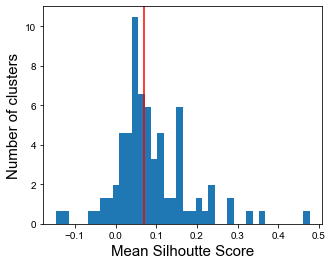

In [133]:
fig=plt.figure(figsize=(5,4))
# x = np.linspace(-0.4,0.4,50)

# fitted_data = norm.pdf(x, mean, var)
# plt.axvline(mean,label='Mean =0.09986',color='darkgreen')
plt.axvline(median,label='Selected Clusters \nthreshold (Median)=0.069',color='red')
plt.hist(Clusters['Mean Silhoutte Values'], density=True,bins=40)
# plt.legend(loc='upper left')
plt.xlabel("Mean Silhoutte Score",fontsize=15)
plt.ylabel("Number of clusters",fontsize=15)
plt.rcParams["font.family"] = "Arial"
# plt.plot(x,fitted_data,'r-')
plt.savefig("MeanthresholdSS_{}_{}.svg".format(minClusterSize,deepSplit),dpi=300,transparent=True)

### Function: `PlotSilhouttePlot`

**Description:** 
This function creates a silhouette plot for visualizing the distribution of silhouette scores across different clusters. The silhouette plot provides an intuitive representation of the density and separation of the formed clusters.

**Parameters:**
- `output_df`: The dataframe used for plotting.
- `labels`: Cluster labels corresponding to each point in the dataframe.

**Functionality:**
1. Sets up a figure and axes with specified dimensions.
2. Defines the x-axis limits for silhouette coefficient values and y-axis limits based on the number of samples and clusters.
3. Calculates the silhouette scores for each sample.
4. Iterates over each cluster to plot the silhouette scores of its samples.
5. Colors each cluster's silhouette plot and labels them.
6. Adds a vertical line indicating the median silhouette score across all clusters.
7. Removes y-axis labels and sets specific x-axis ticks.
8. Saves the plot as a SVG file and displays it.

In [134]:
def PlotSilhouttePlot(output_df,labels):    
    fig, ax = plt.subplots(figsize=[10, 100])
    # fig = plt.figure(figsize=(3, 100))
    ax.set_xlim([-0.2, 0.4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, output_df.shape[0] + (n_clusters + 1) * 10])
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dist, labels=labels, metric='precomputed')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=median, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2,-0.1, 0, 0.2, 0.4,0.6])

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    # ax2.scatter(dist[:, 0], dist[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #             c=colors, edgecolor='k')

    # # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # # Draw white circles at cluster centers
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #             c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                 s=50, edgecolor='k')

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    # plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
    #               "with n_clusters = %d" % n_clusters),
    #              fontsize=14, fontweight='bold')
    plt.savefig("Silhoutte_plot.svg")
    plt.show()

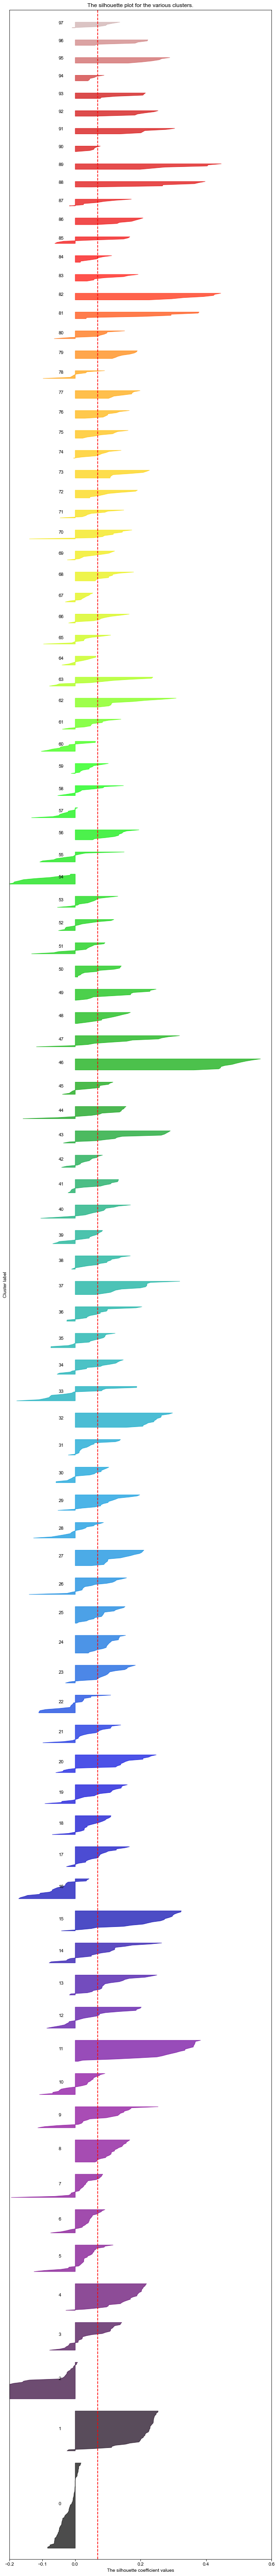

In [135]:
PlotSilhouttePlot(output_df=ProductMatrix,labels=clusters['labels'])

In [179]:
# import re

# from pylab import *
# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt
# def normal(x,mu,sigma,N):
#     '''Returns a normal distribution scaled with <N> as the population size.'''
#     deltax=x[2]-x[1];
#     coef=deltax*N*(1./(sqrt(2.*pi*sigma**2)));
#     return coef*exp(-(x-mu)**2/2/sigma**2)

In [180]:
# x=normal(x=Clusters['Mean Silhoutte Values'],mu=Clusters['Mean Silhoutte Values'].mean(),
#          sigma=Clusters['Mean Silhoutte Values'].std(),N=Clusters.shape[0])

In [181]:
# mean, var =norm.fit(Clusters['Mean Silhoutte Values'])

In [182]:
# fig=plt.figure(figsize=(7,5))
# x = np.linspace(-0.4,0.4,50)

# fitted_data = norm.pdf(x, mean, var)
# # plt.axvline(mean,label='Mean =0.09986',color='darkgreen')
# plt.axvline(median,label='Selected Clusters \nthreshold (Median)=0.094',color='purple')
# plt.hist(Clusters['Mean Silhoutte Values'], density=True)
# plt.legend(loc='upper left')
# plt.xlabel("Mean Silhoutte Score")
# plt.ylabel("Number of clusters")
# plt.plot(x,fitted_data,'r-')
# plt.savefig("MeanthresholdSS.svg",dpi=600)

In [183]:
# Clusters['Mean Silhoutte Values'].hist(bins=50,grid=False)
# median=Clusters['']
# plt.axvline(0.08,label='Selected Clusters \nthreshold =0.08',color='red')
# plt.title("Frequency of mean Silhoutte Scores(SS) of each cluster")
# plt.xlabel("Mean Silhoutte Score")
# plt.ylabel("No. of clusters")
# plt.legend(loc='best')
# plt.savefig("SelectedCluster.svg")

In [136]:
median

0.06909768146490453

In [185]:
# (Clusters['Mean Silhoutte Values'].mean())-(Clusters['Mean Silhoutte Values'].std())

In [186]:
# (Clusters['Mean Silhoutte Values'].mean())

In [137]:
Clusters['Mean Silhoutte Values'].std()

0.09277222955482894

In [138]:
Clusters[Clusters['Mean Silhoutte Values']>median].shape

(49, 2)

In [189]:
# Clusters.sort_values(by=['Mean Silhoutte Values'],ascending=False,inplace=True)

In [190]:
# Clusters.reset_index(inplace=True)

In [191]:
# Clusters.drop(columns=['index'],inplace=True)

### Code Snippet Description

**Purpose:** 
This snippet adds a new column, 'LabelName', to the dataframe `Clusters`, assigning a unique label name to each cluster index.

**Process:**
1. Iterates through each index in the `Clusters` dataframe.
2. For each index, creates a label name in the format 'Label_{index}'.
3. Assigns this label name to the corresponding row in the 'LabelName' column of the `Clusters` dataframe.


In [142]:
for index in Clusters.index:
    # Assign a formatted label name to each cluster index
    Clusters.at[index, 'LabelName'] = "Label_{}".format(index)
for index in Clusters.index:
    if index==0:
        Clusters.at[index,'LabelName']="Unclustered_Cluster"

In [143]:
for index in Cluster_list.index:
#     print(index)
    Cluster_list.at[index,'LabelName']="Label_{}".format((index))
for index in Cluster_list.index:
    if index==0:
        Cluster_list.at[index,'LabelName']="Unclustered_Cluster"

In [144]:
Cluster_list.set_index(['LabelName'],inplace=True)
Clusters.set_index(['LabelName'],inplace=True)

In [145]:
selected_indices=list(set(Clusters.index).intersection(set(Cluster_list.index)))

In [54]:
# Selected_Clusters=Cluster_list.loc[selected_indices]

In [146]:
Clusters.columns

Index(['labels', 'Mean Silhoutte Values'], dtype='object')

In [147]:
Selected_Clusters=Cluster_list

In [148]:
Selected_Clusters['Mean Silhoutte Values']=Clusters['Mean Silhoutte Values']

In [202]:
# Selected_Clusters=Selected_Clusters[Selected_Clusters['Mean Silhoutte Values']>=median]

In [149]:
Selected_Clusters.sort_values(by=['Mean Silhoutte Values'],inplace=True,ascending=False)

In [204]:
# Selected_Clusters=Selected_Clusters['Mean Silhoutte Values']

In [150]:
Selected_Clusters.columns

Index([                      0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12,                      13,
                            14,                      15,
                            16,                      17,
                            18,                      19,
                            20,                      21,
                            22,                      23,
                            24,                      25,
                            26,                      27,
                            28,                      29,
                            30,                      31,
                            32,                      33,
                            34,

In [151]:
for column in Selected_Clusters.columns:
    print(column)
    if type(column)==int:
        print("int")
        Selected_Clusters.rename(columns={column:'Gene_{}'.format(column+1)},inplace=True)
    

0
int
1
int
2
int
3
int
4
int
5
int
6
int
7
int
8
int
9
int
10
int
11
int
12
int
13
int
14
int
15
int
16
int
17
int
18
int
19
int
20
int
21
int
22
int
23
int
24
int
25
int
26
int
27
int
28
int
29
int
30
int
31
int
32
int
33
int
34
int
35
int
36
int
37
int
38
int
39
int
40
int
41
int
42
int
43
int
44
int
45
int
46
int
47
int
48
int
49
int
50
int
51
int
52
int
53
int
54
int
55
int
56
int
57
int
58
int
59
int
60
int
61
int
62
int
63
int
64
int
65
int
66
int
67
int
68
int
69
int
70
int
71
int
72
int
73
int
74
int
75
int
76
int
77
int
labels
Mean Silhoutte Values


In [152]:
Selected_Clusters

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Gene_71,Gene_72,Gene_73,Gene_74,Gene_75,Gene_76,Gene_77,Gene_78,labels,Mean Silhoutte Values
LabelName,,,,,,,,,,,,,,,,,,,,,
Label_46,nduo-6,nduo-3,ctc-1,ndfl-4,nduo-1,nduo-4,ctc-3,nduo-2,nduo-5,ctc-2,...,None,None,None,None,None,None,None,None,46,0.477038
Label_82,fah-1,gst-43,C31H2.4,Y53G8B.1,gst-42,hgo-1,hpd-1,None,None,None,...,None,None,None,None,None,None,None,None,82,0.361924
Label_89,sdha-1,isp-1,mev-1,sdhd-1,sdhb-1,cox-4,None,None,None,None,...,None,None,None,None,None,None,None,None,89,0.326963
Label_88,gln-6,gfat-1,gln-5,hxk-1,T03F6.3,gfat-2,None,None,None,None,...,None,None,None,None,None,None,None,None,88,0.286806
Label_11,vha-3,vha-17,vha-1,spe-5,vha-13,vha-14,vha-4,vha-15,unc-32,vha-18,...,None,None,None,None,None,None,None,None,11,0.281720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Label_60,alh-3,Y71F9B.9,dhs-21,K09A9.6,R04B5.6,aagr-1,Y105E8B.9,aagr-2,R04B5.5,R08D7.7,...,None,None,None,None,None,None,None,None,60,-0.024482
Label_57,ama-1,pisy-1,Y48E1B.3,plpp-1.1,gld-2,ZK673.2,M57.2,gld-4,cdgs-1,bli-4,...,None,None,None,None,None,None,None,None,57,-0.037177
Label_16,rpb-3,rpb-12,rpb-6,M04D5.1,Y49E10.4,F40F8.1,rpb-7,rpb-11,sucl-2,cept-2,...,None,None,None,None,None,None,None,None,16,-0.064638


In [153]:
Selected_Clusters=Selected_Clusters[['Mean Silhoutte Values','Gene_1', 'Gene_2', 'Gene_3', 'Gene_4', 'Gene_5', 'Gene_6', 'Gene_7',
       'Gene_8', 'Gene_9', 'Gene_10', 'Gene_11', 'Gene_12', 'Gene_13',
       'Gene_14', 'Gene_15', 'Gene_16', 'Gene_17', 'Gene_18', 'Gene_19', 'Gene_20', 'Gene_21', 'Gene_22', 'Gene_23',
       'Gene_24', 'Gene_25', 'Gene_26', 'Gene_27', 'Gene_28','Gene_29', 'Gene_30', 'Gene_31', 'Gene_32', 'Gene_33',
       'Gene_34', 'Gene_35', 'Gene_36', 'Gene_37', 'Gene_38']]

In [154]:
Selected_Clusters.reset_index(inplace=True)

In [155]:
for index in Selected_Clusters.index:
#     print(index)
    Selected_Clusters.at[index,'ClusterName']="Cluster_{}".format((index+1))

/home/nandas/miniconda3/envs/metabolism/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/nandas/miniconda3/envs/metabolism/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [156]:
Selected_Clusters.set_index(['ClusterName'],inplace=True)

In [212]:
# Clusters.drop(columns=['ClusterName'],inplace=True)

In [213]:
# Selected_Clusters_sets=Clusters.sort_values(ascending=False,by=['Mean Silhoutte Values'])

In [157]:
Selected_Clusters.drop(columns=['LabelName'],inplace=True)

/home/nandas/miniconda3/envs/metabolism/lib/python3.6/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [215]:
# Selected_Clusters=Clusters[Clusters['Mean Silhoutte Values']>=median]

In [216]:
# Selected_Clusters

In [158]:
Selected_Clusters.to_csv("ClusterList_6_3_021523.csv")

Text(0, 0.5, 'No. of clusters')

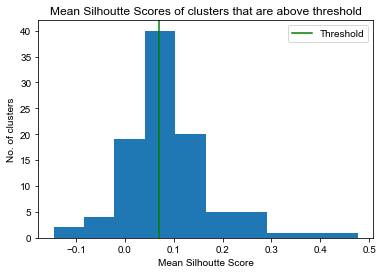

In [159]:
Selected_Clusters['Mean Silhoutte Values'].hist(grid=False)
plt.title('Mean Silhoutte Scores of clusters that are above threshold')
plt.axvline(x=median,label='Threshold',color='green')
plt.xlabel("Mean Silhoutte Score")
plt.legend(loc='best')
plt.ylabel("No. of clusters")

In [160]:
Cluster_list

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Gene_71,Gene_72,Gene_73,Gene_74,Gene_75,Gene_76,Gene_77,Gene_78,labels,Mean Silhoutte Values
LabelName,,,,,,,,,,,,,,,,,,,,,
Label_46,nduo-6,nduo-3,ctc-1,ndfl-4,nduo-1,nduo-4,ctc-3,nduo-2,nduo-5,ctc-2,...,None,None,None,None,None,None,None,None,46,0.477038
Label_82,fah-1,gst-43,C31H2.4,Y53G8B.1,gst-42,hgo-1,hpd-1,None,None,None,...,None,None,None,None,None,None,None,None,82,0.361924
Label_89,sdha-1,isp-1,mev-1,sdhd-1,sdhb-1,cox-4,None,None,None,None,...,None,None,None,None,None,None,None,None,89,0.326963
Label_88,gln-6,gfat-1,gln-5,hxk-1,T03F6.3,gfat-2,None,None,None,None,...,None,None,None,None,None,None,None,None,88,0.286806
Label_11,vha-3,vha-17,vha-1,spe-5,vha-13,vha-14,vha-4,vha-15,unc-32,vha-18,...,None,None,None,None,None,None,None,None,11,0.281720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Label_60,alh-3,Y71F9B.9,dhs-21,K09A9.6,R04B5.6,aagr-1,Y105E8B.9,aagr-2,R04B5.5,R08D7.7,...,None,None,None,None,None,None,None,None,60,-0.024482
Label_57,ama-1,pisy-1,Y48E1B.3,plpp-1.1,gld-2,ZK673.2,M57.2,gld-4,cdgs-1,bli-4,...,None,None,None,None,None,None,None,None,57,-0.037177
Label_16,rpb-3,rpb-12,rpb-6,M04D5.1,Y49E10.4,F40F8.1,rpb-7,rpb-11,sucl-2,cept-2,...,None,None,None,None,None,None,None,None,16,-0.064638


In [161]:
Cluster_list.to_csv("ClusterSetsFluxRed_062722_6_3.gmt",sep='\t')

In [162]:
Selected_Clusters

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38
ClusterName,,,,,,,,,,,,,,,,,,,,,
Cluster_1,0.477038,nduo-6,nduo-3,ctc-1,ndfl-4,nduo-1,nduo-4,ctc-3,nduo-2,nduo-5,...,None,None,None,None,None,None,None,None,None,None
Cluster_2,0.361924,fah-1,gst-43,C31H2.4,Y53G8B.1,gst-42,hgo-1,hpd-1,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_3,0.326963,sdha-1,isp-1,mev-1,sdhd-1,sdhb-1,cox-4,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_4,0.286806,gln-6,gfat-1,gln-5,hxk-1,T03F6.3,gfat-2,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_5,0.281720,vha-3,vha-17,vha-1,spe-5,vha-13,vha-14,vha-4,vha-15,unc-32,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_94,-0.024482,alh-3,Y71F9B.9,dhs-21,K09A9.6,R04B5.6,aagr-1,Y105E8B.9,aagr-2,R04B5.5,...,None,None,None,None,None,None,None,None,None,None
Cluster_95,-0.037177,ama-1,pisy-1,Y48E1B.3,plpp-1.1,gld-2,ZK673.2,M57.2,gld-4,cdgs-1,...,None,None,None,None,None,None,None,None,None,None
Cluster_96,-0.064638,rpb-3,rpb-12,rpb-6,M04D5.1,Y49E10.4,F40F8.1,rpb-7,rpb-11,sucl-2,...,None,None,None,None,None,None,None,None,None,None


In [163]:
Selected_Clusters.to_csv("ProductMatrix_AllClusterSets_063022_6_3.gmt",sep='\t')

In [164]:
Selected_Clusters.to_csv("ProductMatrix_AllClusterSets_063022_6_3.csv")

In [165]:
Selected_Clusters

,Mean Silhoutte Values,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_29,Gene_30,Gene_31,Gene_32,Gene_33,Gene_34,Gene_35,Gene_36,Gene_37,Gene_38
ClusterName,,,,,,,,,,,,,,,,,,,,,
Cluster_1,0.477038,nduo-6,nduo-3,ctc-1,ndfl-4,nduo-1,nduo-4,ctc-3,nduo-2,nduo-5,...,None,None,None,None,None,None,None,None,None,None
Cluster_2,0.361924,fah-1,gst-43,C31H2.4,Y53G8B.1,gst-42,hgo-1,hpd-1,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_3,0.326963,sdha-1,isp-1,mev-1,sdhd-1,sdhb-1,cox-4,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_4,0.286806,gln-6,gfat-1,gln-5,hxk-1,T03F6.3,gfat-2,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Cluster_5,0.281720,vha-3,vha-17,vha-1,spe-5,vha-13,vha-14,vha-4,vha-15,unc-32,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster_94,-0.024482,alh-3,Y71F9B.9,dhs-21,K09A9.6,R04B5.6,aagr-1,Y105E8B.9,aagr-2,R04B5.5,...,None,None,None,None,None,None,None,None,None,None
Cluster_95,-0.037177,ama-1,pisy-1,Y48E1B.3,plpp-1.1,gld-2,ZK673.2,M57.2,gld-4,cdgs-1,...,None,None,None,None,None,None,None,None,None,None
Cluster_96,-0.064638,rpb-3,rpb-12,rpb-6,M04D5.1,Y49E10.4,F40F8.1,rpb-7,rpb-11,sucl-2,...,None,None,None,None,None,None,None,None,None,None
